# Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import wfdb
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.decomposition import PCA

In [2]:
# Choosing the device you want : cpu , gpu or tpu

device_type = input("Please choose the type of device you want to use : ")
if device_type=="cpu":
    device = torch.device("cpu")
elif device_type=="gpu":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
elif device_type=="tpu":
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()

print("\nYou are using ", device)

Please choose the type of device you want to use : gpu

You are using  cuda:0


In [3]:
import HelpECG as he

# Data Loading

In [4]:
signals,fields = wfdb.rdsamp("../mit-bih-arrhythmia-database-1.0.0/100")
print(fields)

{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


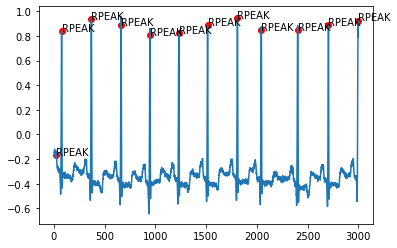

In [5]:
signal_v5 = signals[:,0].reshape(-1)

attr_check = wfdb.rdann('../mit-bih-arrhythmia-database-1.0.0/100',extension='atr')

plt.plot(signal_v5[:3000])
for i in attr_check.sample[attr_check.sample<3000]:
    plt.scatter(i,signal_v5[i],marker='o',c='r')
    plt.annotate("RPEAK",(i,signal_v5[i]))
plt.show()

# Data Preprocessing

In [6]:
records = np.loadtxt('../mit-bih-arrhythmia-database-1.0.0/RECORDS',delimiter='\n').astype(int)
print(records)

[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]


In [7]:
beat_classes = ['A','L','N','/','R','V','f','F','!','j']
beat_transform = {'A':0,'L':1,'N':2,'/':3,'R':4,'V':5,'f':6,'F':7,'!':8,'j':9}
beat_inv_transform = {v:k for k,v in beat_transform.items()}

In [18]:
batch_size = 31
batch_size_val = 1217
batch_size_test = 1685

In [8]:
ecg_signals = {}
ecg_labels = {}

for record in records :
    
    temp_signals,temp_fields = wfdb.rdsamp('../mit-bih-arrhythmia-database-1.0.0/'+str(record))
    test_attr = wfdb.rdann('../mit-bih-arrhythmia-database-1.0.0/'+str(record),extension='atr')
    ecg_labels[record] = {}
    ecg_labels[record]['sample'] = test_attr.sample
    ecg_labels[record]['symbol'] = test_attr.symbol
    ecg_labels[record]['full'] = [ (symbol,sample) for symbol,sample in zip(test_attr.symbol,test_attr.sample) ] 
    ecg_signals[record] = {}
    ecg_signals[record]['leads'] = temp_fields['sig_name']

    for n,i in enumerate(ecg_signals[record]['leads']):

        ecg_signals[record][i] = temp_signals[:,n].reshape(-1)

# Generic Data Preprocessor

In [9]:
def data_processor(n_number,records,device,device_type,ecg_labels,beat_classes,beat_transform,beat_inv_transform):
    
    """ Preprocess the data for training and evaluation of HeartNetEC Model"""
    
    ecg_signals = {}
    fs = 360 # Sampling Rate
    bp = 0.35
    ap = 0.45
    ecg_signals[0] = pd.read_parquet('mit_denoised_ecg_lead0_'+str(n_number)+'db'+'.parquet')
    ecg_signals[1] = pd.read_parquet('mit_denoised_ecg_lead1_'+str(n_number)+'db'+'.parquet')
    ECGSignals = {}
    
    for record in records:
        for lead in [0,1]:
            ECGSignals[record] = {}
            ECGSignals[record][lead] = ecg_signals[lead][str(record)]
            
    ecg_beat_matrix = []
    for record in records:

        for lead in [0,1]:

            length = ecg_signals[lead][str(record)].shape[0]

            for sym,samp in ecg_labels[record]['full']:

                if (((samp-bp*fs)>0) and ((samp+ap*fs)<length) and (sym in beat_classes)):

                    ecg_beat_matrix.append([ecg_signals[lead][str(record)][int(samp-bp*fs):int(samp+ap*fs)],beat_transform[sym]])

    ecg_beat_matrix = np.array(ecg_beat_matrix)
    
    X_train, X_test_, y_train, y_test_ = train_test_split(ecg_beat_matrix[:,0],ecg_beat_matrix[:,1],test_size=0.2,shuffle=True,stratify=ecg_beat_matrix[:,1],random_state=1)
    X_test,X_val,y_test,y_val = train_test_split(X_test_,y_test_,test_size=0.5,shuffle=True,stratify=y_test_,random_state=1)

    X_train = np.array(list(X_train))
    y_train = np.array(list(y_train))
    X_val = np.array(list(X_val))
    y_val = np.array(list(y_val))
    X_test = np.array(list(X_test))
    y_test = np.array(list(y_test))
    
    batch_size = 31
    n_batches = X_train.shape[0]/batch_size

    train_dict = {}
    train_dict['batches'] = {}
    val_dict = {}
    test_dict = {}

    train_dict['X_train'] = X_train
    train_dict['y_train'] = y_train
    val_dict['X_val'] = X_val
    val_dict['y_val'] = y_val
    test_dict['X_test'] = X_test
    test_dict['y_test'] = y_test

    train_dict['batches']['X'] = np.split(X_train,n_batches)
    train_dict['batches']['y'] = np.split(y_train,n_batches)
    
    batch_size_val = 1217
    n_batches_val = X_val.shape[0]/batch_size_val

    val_dict['batches'] = {}

    val_dict['batches']['X'] = np.split(X_val,n_batches_val)
    val_dict['batches']['y'] = np.split(y_val,n_batches_val)
    
    batch_size_test = 1685
    n_batches_test = X_test.shape[0]/batch_size_test


    test_dict['batches'] = {}

    test_dict['batches']['X'] = np.split(X_test,n_batches_test)
    test_dict['batches']['y'] = np.split(y_test,n_batches_test)
    
    config = {}

    config['batch_size'] = batch_size
    config['n_batches'] = n_batches
    config['batch_size_val'] = batch_size_val
    config['n_batches_val'] = n_batches_val
    config['batch_size_test'] = batch_size_test
    config['n_batches_test'] = n_batches_test
    config['feature_length'] = 288
    config['lr'] = 0.001
    config['device'] = device
    config['device_type'] = device_type
    config['beat_classes'] = beat_classes
    config['beat_transform'] = beat_transform
    config['beat_inv_transform'] = beat_inv_transform
    
    return train_dict,val_dict,test_dict,config

# HeartNetEC for Beat Classification

In [10]:
class HeartNetEC(nn.Module):

    def __init__(self,length):


        super().__init__()
        self.length = length

        self.descend_Stage1 = nn.Sequential(

            nn.Conv1d(in_channels=1,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,1,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU(),
            nn.Conv1d(in_channels=4,out_channels=4,kernel_size=9,stride=1,padding=4), # (1,4,L) --> (1,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU()
        )

        self.descend_Stage1_i_Stage2 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,4,L) --> (N,4,L/2)

        self.descend_Stage2 = nn.Sequential(

            nn.Conv1d(in_channels=4,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,4,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU(),
            nn.Conv1d(in_channels=8,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,8,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU()
        )

        self.descend_Stage2_i_Stage3 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,8,L/2) --> (N,8,L/4)

        self.descend_Stage3 = nn.Sequential(

            nn.Conv1d(in_channels=8,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,8,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,16,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),#(N,16,L/4) --> (N,16,L/4)
            nn.ReLU()
        )

        self.descend_Stage3_i_Stage4 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,16,L/4) --> (N,16,L/8)

        self.descend_Stage4 = nn.Sequential(

            nn.Conv1d(in_channels=16,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,16,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),# (N,32,L/8) --> (N,32,L/8)
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,32,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),#(N,32,L/8) --> (N,32,L/8)
            nn.ReLU()
        )

        self.descend_Stage4_i_floor = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,32,L/8) --> (N,32,L/16)

        self.floor = nn.Sequential(

            nn.Conv1d(in_channels=32,out_channels=64,kernel_size=9,stride=1,padding=4), # (N,32,L/16) --> (N,64,L/16)
            nn.BatchNorm1d(64),# (N,64,L/16) --> (N,64,L/16)
            nn.ReLU(),
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=9,stride=1,padding=4), # (N,64,L/16) --> (N,64,L/16)
            nn.BatchNorm1d(64),# (N,64,L/16) --> (N,64,L/16)
            nn.ReLU()
        )

        self.ascend_floor_i_Stage4 = nn.ConvTranspose1d(in_channels=64,out_channels=64,kernel_size=8,stride=2,padding=3) # (N,64,L/16) --> (N,64,L/8)

        self.ascend_Stage4 = nn.Sequential(

            nn.Conv1d(in_channels=96,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,96,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),# (N,32,L/8) --> (N,32,L/8)
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,32,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),#(N,32,L/8) --> (N,32,L/8)
            nn.ReLU()
        )

        self.ascend_Stage4_i_Stage3 = nn.ConvTranspose1d(in_channels=32,out_channels=32,kernel_size=8,stride=2,padding=3) # (N,32,L/8) --> (N,32,L/4)

        self.ascend_Stage3 = nn.Sequential(

            nn.Conv1d(in_channels=48,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,48,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,16,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU()
        )

        self.ascend_Stage3_i_Stage2 = nn.ConvTranspose1d(in_channels=16,out_channels=16,kernel_size=8,stride=2,padding=3) # (N,16,L/4) --> (N,16,L/2)

        self.ascend_Stage2 = nn.Sequential(

            nn.Conv1d(in_channels=24,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,24,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU(),
            nn.Conv1d(in_channels=8,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,8,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU()
        )

        self.ascend_Stage2_i_Stage1 = nn.ConvTranspose1d(in_channels=8,out_channels=8,kernel_size=8,stride=2,padding=3) # (N,8,L/2) --> (N,8,L)

        self.ascend_Stage1 = nn.Sequential(

            nn.Conv1d(in_channels=12,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,12,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU(),
            nn.Conv1d(in_channels=4,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,4,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU()
        )

        self.fe_output = nn.Conv1d(in_channels=4,out_channels=1,kernel_size=1)          # (N,4,L) --> (N,1,L)

        self.cl_stage_1 = nn.Sequential(
            
            nn.Linear(in_features=self.length,out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.final_stage = nn.Linear(in_features=64,out_features=10)


    def forward(self,x):

  

        # Pass through Descend Stage-1

        d_1 = self.descend_Stage1(x)



        # Move to Descend Stage-2

        d_1_i_2 = self.descend_Stage1_i_Stage2(d_1)

 

        # Pass through Descend Stage-2

        d_2 = self.descend_Stage2(d_1_i_2)

  

        # Move to Descend Stage-3

        d_2_i_3 = self.descend_Stage2_i_Stage3(d_2)



        # Pass through Descend Stage-3

        d_3 = self.descend_Stage3(d_2_i_3)



        # Move to Descend Stage-4


        d_3_i_4 = self.descend_Stage3_i_Stage4(d_3)



        # Pass through Descend Stage-4

        d_4 = self.descend_Stage4(d_3_i_4)



        # Move to Floor

        d_4_i_f = self.descend_Stage4_i_floor(d_4)



        # Pass through Floor

        d_f = self.floor(d_4_i_f)



        # Move to Ascend Stage-4

        a_f_i_4 = self.ascend_floor_i_Stage4(d_f)


        # Prepare for Ascend Stage-4



        a_p_4 = torch.cat((d_4,a_f_i_4),dim=1)


        # Pass through Ascend Stage-4


        a_4 = self.ascend_Stage4(a_p_4)


        # Move to Ascend Stage-3


        a_4_i_3 = self.ascend_Stage4_i_Stage3(a_4)


        # Prepare for Ascend Stage-3


        a_p_3 = torch.cat((d_3,a_4_i_3),dim=1)


        # Pass through Ascend Stage-3


        a_3 = self.ascend_Stage3(a_p_3)


        # Move to Ascend Stage-2

        a_3_i_2 = self.ascend_Stage3_i_Stage2(a_3)


        # Prepare for Ascend Stage-2

        a_p_2 = torch.cat((d_2,a_3_i_2),dim=1)


        # Pass through Stage-2

        a_2 = self.ascend_Stage2(a_p_2)


        # Move to Ascend Stage-1

        a_2_i_1 = self.ascend_Stage2_i_Stage1(a_2)



        # Prepare for Ascend Stage-1

        a_p_1 = torch.cat((d_1,a_2_i_1),dim=1)


        # Pass through Ascend Stage-1


        a_1 = self.ascend_Stage1(a_p_1)


        # Pass through Final Stage of Feature Extractor


        fe_output = self.fe_output(a_1)

        # Pass through FF Stage - 1

        cl_out_1 = self.cl_stage_1(fe_output.squeeze())

        # Pass through the Final Classifier Stage

        final_output = self.final_stage(cl_out_1)


        return final_output

In [11]:
tst = HeartNetEC(288)
print(tst)

HeartNetEC(
  (descend_Stage1): Sequential(
    (0): Conv1d(1, 4, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(4, 4, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (descend_Stage1_i_Stage2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (descend_Stage2): Sequential(
    (0): Conv1d(4, 8, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(8, 8, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (descend_Stage2_i_Stage3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (descend_Stage3): Sequ

# Evaluator

## Helper Functions

In [12]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories,
                annot_kws={"size":17,"weight": "bold"})

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

    plt.show()

In [13]:
def evaluation(model,config,data,trueLabels,mode,name):

    """ Main Evaluator Function """

    predictedLabels = []

    for data_batch in data:

        data_batch = torch.FloatTensor(data_batch.reshape(config[name],1,-1)).to(device)

        with torch.no_grad():
            temp_predictions = model(data_batch)

    
        del data_batch
        torch.cuda.empty_cache()
        
        predictedLabels = np.append(predictedLabels,list(np.argmax(np.array(temp_predictions.cpu()),axis=1)))




    conf_mat = confusion_matrix(trueLabels,predictedLabels)

    num_TP = {}
    num_FP = {}
    num_FN = {}
    num_TN = {}

    num_TP['all'] = 0
    num_FP['all'] = 0
    num_FN['all'] = 0


    for beat_type in config['beat_classes']:

        num_TP[beat_type] = float(conf_mat[config['beat_transform'][beat_type],config['beat_transform'][beat_type]])
        num_FP[beat_type] = np.sum(conf_mat[:,config['beat_transform'][beat_type]]) - num_TP[beat_type]
        num_FN[beat_type] = np.sum(conf_mat[config['beat_transform'][beat_type],:]) - num_TP[beat_type]
        num_TN[beat_type] = np.sum(conf_mat) - num_TP[beat_type] - num_FP[beat_type] - num_FN[beat_type]

        num_TP['all'] += num_TP[beat_type]
        num_FP['all'] += num_FP[beat_type]
        num_FN['all'] += num_FN[beat_type]

    precision_full = (num_TP['all']/(num_TP['all']+num_FP['all']))
    sensitivity_full = (num_TP['all']/(num_TP['all']+num_FN['all']))
    f1_full = (2*precision_full*sensitivity_full)/(precision_full+sensitivity_full)
    accuracy_full = (num_TP['all'])/np.sum(conf_mat)

    if mode == "Validation":

        return {"accuracy":accuracy_full,
                "precision":precision_full,
                "sensitivity":sensitivity_full,
                "F1":f1_full
               }

    if mode == "Evaluation":

        metrics = classification_report(trueLabels,predictedLabels,target_names=config['beat_classes'],output_dict=True)

        for beat_type in config['beat_classes']:

            metrics[beat_type]["Accuracy"] = (num_TP[beat_type]+num_TN[beat_type])/np.sum(conf_mat)

        metrics['all'] = {}

        metrics['all']['precision'] = precision_full 
        metrics['all']['recall'] = sensitivity_full
        metrics['all']['f1-score'] = f1_full
        metrics['all']['Accuracy'] = accuracy_full

        return metrics,conf_mat

# Core Training Setup

## Core Training Function

In [14]:
def ultimate_trainer(trainData,valData,testData,epochs,config,n_number,verbose=False,visualize=True,download_model=False):

    """ Trains HeartNet Models for Beat Classification """

    print("------------------------------------------------------------------------------------------")
    print("\t\t\t TRAINING EXPERIMENT")
    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING CONFIGURATION")
    print("------------------------------------------------------------------------------------------")

    print("--> The HeartNet Model is being trained for Beat Classification")
    
    print("--> Noise Level : "+str(n_number)+" dB")
    print("--> You are using a  " + config['device_type'])
    print("--> The epochs specified for training : ",epochs)
    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING")
    print("------------------------------------------------------------------------------------------")


    # Model Instantiation and Model Parameters

    model = HeartNetEC(config['feature_length'])

    model = model.to(config['device'])

    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(),lr=config['lr'])

    # Some variables for Training and Validation Visualization
    sensitivity_plot_val = []
    precision_plot_val = []
    F1_plot_val = []
    accuracy_plot_val = []

    loss_train_plot = []
    sensitivity_plot_train = []
    precision_plot_train = []
    F1_plot_train = []
    accuracy_plot_train = []

    # Some variables for Checkpointing

    min_train_loss = 1000
    max_val_F1 = 0
    max_train_F1 = 0

    # Training

    for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):

        # Now go through each batch

        for train_batch,label_batch in zip(trainData['batches']['X'],trainData['batches']['y']):

            # Convert to Tensors

            train_batch = torch.FloatTensor(train_batch.reshape(batch_size,1,-1))

            label_batch = torch.LongTensor(label_batch)

            # Move to Specified Device

            train_batch,label_batch = train_batch.to(device),label_batch.to(device)

            # Initialize gradients to zero
            
            optimizer.zero_grad()

            # Forward Pass

            prediction = model(train_batch)

            # Compute the Loss
            

            loss = loss_fn(prediction,label_batch)

            # Backpropagation

            loss.backward()

            # Take a Step and update the parameters

            optimizer.step()

            # Now Checkpointing the model loss

            if min_train_loss > loss.item() :

                min_train_loss = loss.item()
                #best_train_model = copy.deepcopy(model.state_dict())
                print("+-> Min Training Loss : "+str(min_train_loss))

            # Freeing the GPU

            del train_batch,label_batch,prediction
            torch.cuda.empty_cache()

        # Some Bookkeeping for Training

        loss_train_plot.append(loss.item())

        # Put the Model in Evaluation Mode

        model.eval()

        # Evaluating Train Data

        train_metrics,val_metrics = evaluation(model=model,config=config,data=trainData['batches']['X'],trueLabels=trainData['y_train'],mode='Validation',name='batch_size'),evaluation(model=model,config=config,data=valData['batches']['X'],trueLabels=valData['y_val'],mode='Validation',name='batch_size_val')


        # Bookkeeping

        sensitivity_plot_train.append(train_metrics['sensitivity'])
        precision_plot_train.append(train_metrics['precision'])
        F1_plot_train.append(train_metrics['F1'])
        accuracy_plot_train.append(train_metrics['accuracy'])

        sensitivity_plot_val.append(val_metrics['sensitivity'])
        precision_plot_val.append(val_metrics['precision'])
        F1_plot_val.append(val_metrics['F1'])
        accuracy_plot_val.append(val_metrics['accuracy'])

        # Checkpointing the Best Validation Model

        if max_val_F1 < val_metrics['F1']:

            max_val_F1 = val_metrics['F1']

            best_val_model = copy.deepcopy(model.state_dict())

            print("+-> Maximum Validation F1 (in %) obtained is ",max_val_F1)

        # Put the Model back in Training Mode

        model.train()

    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING COMPLETE")
    print("------------------------------------------------------------------------------------------")
    plt.plot(loss_train_plot,'r-')
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss : Cross Entropy Loss")
    plt.title("LOSS PLOT")
    plt.show()

    if visualize :
        print("------------------------------------------------------------------------------------------")
        print("\t VISUALIZATION ")
        print("------------------------------------------------------------------------------------------")
        # Visualization

        plt.plot(accuracy_plot_train,'r-',label='Train Data')
        plt.plot(accuracy_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()


        plt.plot(sensitivity_plot_train,'r-',label='Train Data')
        plt.plot(sensitivity_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Sensitivity")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        plt.plot(precision_plot_train,'r-',label='Train Data')
        plt.plot(precision_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Precision")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        plt.plot(F1_plot_train,'r-',label='Train Data')
        plt.plot(F1_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("F1 Score")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        print("------------------------------------------------------------------------------------------")
        print("\t METRICS FOR BEST VALIDATION MODEL")
        print("------------------------------------------------------------------------------------------")
        print("VALIDATION SET")
        print("------------------------------------------------------------------------------------------")

        model.load_state_dict(best_val_model)

        model.eval()

        best_metrics_val,conf_matrix_val = evaluation(model=model,config=config,data=valData['batches']['X'],trueLabels=valData['y_val'],mode='Evaluation',name='batch_size_val')

        print("Confusion Matrix\n\n")

        make_confusion_matrix(conf_matrix_val,
                          categories=config['beat_classes'],
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(15,15),
                          cmap='Blues',
                          title=None)

        print("\n\nMetrics\n\n")

        df_val = pd.DataFrame.from_dict(best_metrics_val)
        df_val = df_val.drop(['accuracy','macro avg','weighted avg'],axis=1)
        df_val = df_val.drop(['support'],axis=0)
        display(df_val.T)

        print("------------------------------------------------------------------------------------------")
        print("TEST SET")
        print("------------------------------------------------------------------------------------------")

        best_metrics_test,conf_matrix_test = evaluation(model=model,config=config,data=testData['batches']['X'],trueLabels=testData['y_test'],mode='Evaluation',name='batch_size_test')

        print("Confusion Matrix\n\n")

        make_confusion_matrix(conf_matrix_test,
                          categories=config['beat_classes'],
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(15,15),
                          cmap='Blues',
                          title=None)

        print("\n\nMetrics\n\n")

        df_test = pd.DataFrame.from_dict(best_metrics_test)
        df_test = df_test.drop(['accuracy','macro avg','weighted avg'],axis=1)
        df_test = df_test.drop(['support'],axis=0)
        display(df_test.T)

        print("------------------------------------------------------------------------------------------")
        print("\t EVALUATION COMPLETE")
        print("------------------------------------------------------------------------------------------")

    # Now download the model for future use

    if download_model :

        print("DOWNLOADING MODEL ...")
        
        name  = "HRT_NET_MODEL_MIT_DENOISED_"+str(n_number)+"_dB"

        torch.save(best_val_model,name)


        print("DOWNLOADING COMPLETE !!!")


    return best_val_model

# Saved Model Evaluator

In [15]:
def savedModelEvaluator(filename,trainData,valData,testData,config):
    
    print("------------------------------------------------------------------------------------------")
    print("\t METRICS FOR BEST VALIDATION MODEL")
    print("------------------------------------------------------------------------------------------")
    print("VALIDATION SET")
    print("------------------------------------------------------------------------------------------")

    model = HeartNetEC(config['feature_length'])

    model = model.to(config['device'])

    model.load_state_dict(torch.load(filename,map_location=config['device']))

    model.eval()

    best_metrics_val,conf_matrix_val = evaluation(model=model,config=config,data=valData['batches']['X'],trueLabels=valData['y_val'],mode='Evaluation',name='batch_size_val')

    print("Confusion Matrix\n\n")

    make_confusion_matrix(conf_matrix_val,
                      categories=config['beat_classes'],
                      count=True,
                      percent=False,
                      cbar=True,
                      xyticks=True,
                      xyplotlabels=True,
                      sum_stats=False,
                      figsize=(15,15),
                      cmap='Blues',
                      title=None)

    print("\n\nMetrics\n\n")

    df_val = pd.DataFrame.from_dict(best_metrics_val)
    df_val = df_val.drop(['accuracy','macro avg','weighted avg'],axis=1)
    df_val = df_val.drop(['support'],axis=0)
    display(df_val.T)

    print("------------------------------------------------------------------------------------------")
    print("TEST SET")
    print("------------------------------------------------------------------------------------------")

    best_metrics_test,conf_matrix_test = evaluation(model=model,config=config,data=testData['batches']['X'],trueLabels=testData['y_test'],mode='Evaluation',name='batch_size_test')

    print("Confusion Matrix\n\n")

    make_confusion_matrix(conf_matrix_test,
                      categories=config['beat_classes'],
                      count=True,
                      percent=False,
                      cbar=True,
                      xyticks=True,
                      xyplotlabels=True,
                      sum_stats=False,
                      figsize=(15,15),
                      cmap='Blues',
                      title=None)

    print("\n\nMetrics\n\n")

    df_test = pd.DataFrame.from_dict(best_metrics_test)
    df_test = df_test.drop(['accuracy','macro avg','weighted avg'],axis=1)
    df_test = df_test.drop(['support'],axis=0)
    display(df_test.T)

    print("------------------------------------------------------------------------------------------")
    print("\t EVALUATION COMPLETE")
    print("------------------------------------------------------------------------------------------")


# Final Data Preprocessing

In [39]:
TRAIN = {}
VAL = {}
TEST = {}
CONFIG = {}

for i in [5,10,15,20,25,30,35,40,45,50]:
    
    TRAIN[i],VAL[i],TEST[i],CONFIG[i] = data_processor(i,records,device,device_type,ecg_labels,beat_classes,beat_transform,beat_inv_transform)


# Effect of Noise Addition on Beat Classification (Robustness Check)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 5 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-40-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.0931029319763184
+-> Min Training Loss : 2.0156002044677734
+-> Min Training Loss : 1.930332064628601
+-> Min Training Loss : 1.8110700845718384
+-> Min Training Loss : 1.6969375610351562
+-> Min Training Loss : 1.6965222358703613
+-> Min Training Loss : 1.5733081102371216
+-> Min Training Loss : 1.5057474374771118
+-> Min Training Loss : 1.4644505977630615
+-> Min Training Loss : 1.4017027616500854
+-> Min Training Loss : 1.32947838306427
+-> Min Training Loss : 1.2127734422683716
+-> Min Training Loss : 1.153159260749817
+-> Min Training Loss : 1.090936303138733
+-> Min Training Loss : 1.062164068222046
+-> Min Training Loss : 0.9307364225387573
+-> Min Training Loss : 0.9071745276451111
+-> Min Training Loss : 0.8450533747673035
+-> Min Training Loss : 0.7366088628768921
+-> Min Training Loss : 0.66268390417099
+-> Min Training Loss : 0.613182544708252
+-> Min Training Loss : 0.5757830739021301
+-> Min Training Loss : 0.5703607797622681
+-> Min Training Los

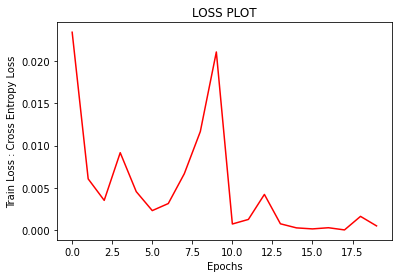

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


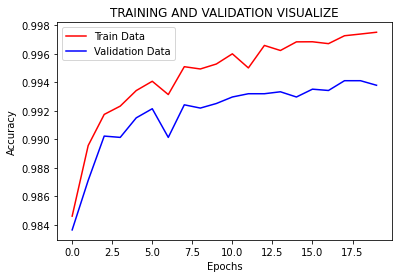

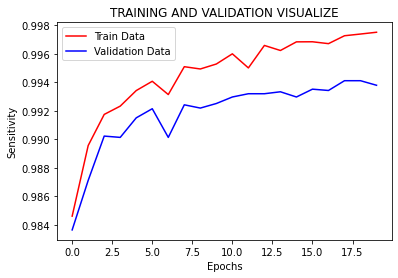

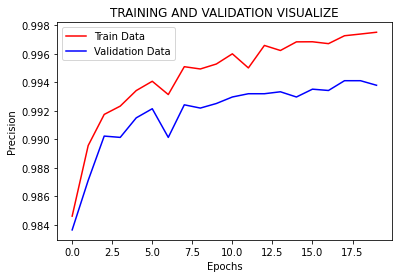

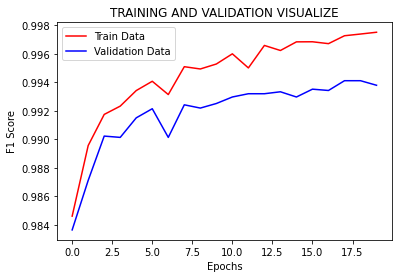

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




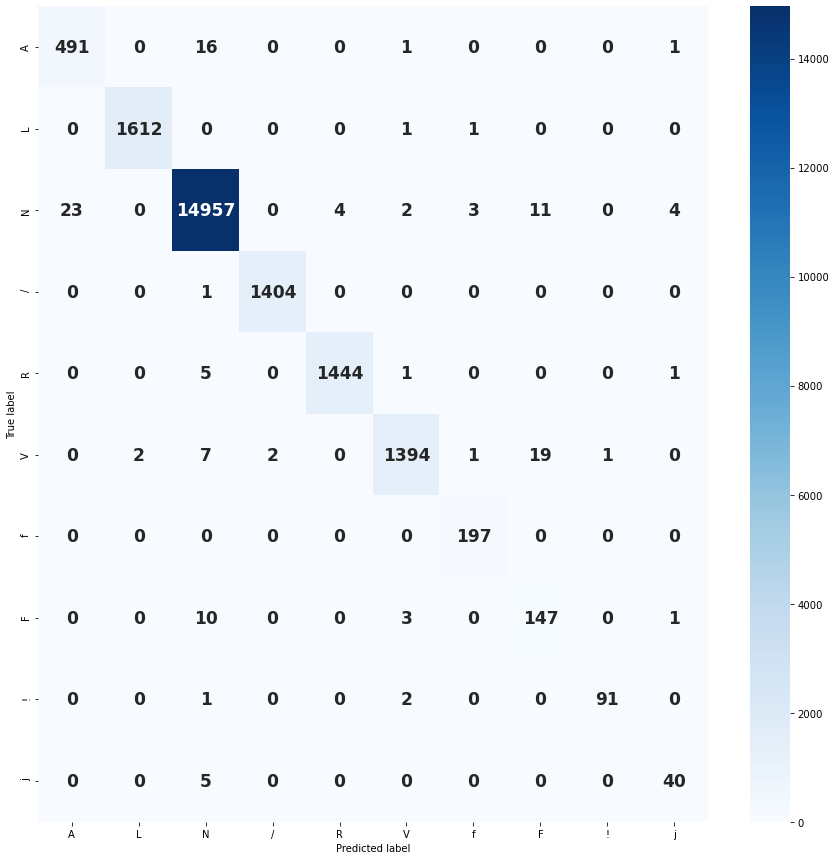



Metrics




precision    recall  f1-score  Accuracy
A     0.955253  0.964637  0.959922  0.998128
L     0.998761  0.998761  0.998761  0.999817
N     0.997000  0.996868  0.996934  0.995800
/     0.998578  0.999288  0.998933  0.999863
R     0.997238  0.995176  0.996206  0.999498
V     0.992877  0.977560  0.985159  0.998083
f     0.975248  1.000000  0.987469  0.999772
F     0.830508  0.913043  0.869822  0.997991
!     0.989130  0.968085  0.978495  0.999817
j     0.851064  0.888889  0.869565  0.999452
all   0.994111  0.994111  0.994111  0.994111

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




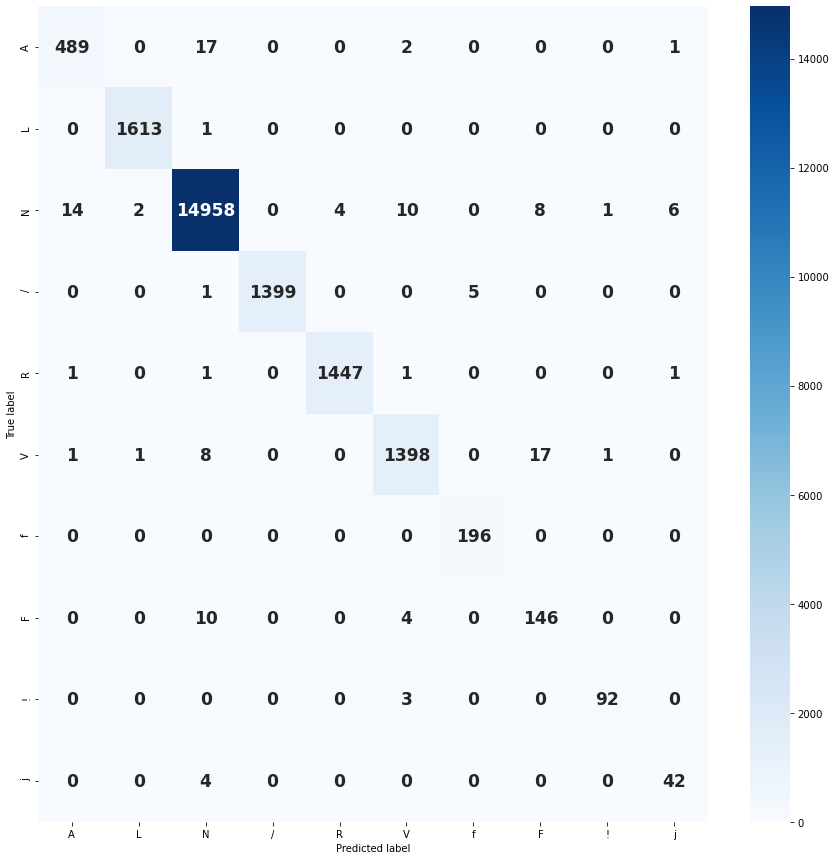



Metrics




precision    recall  f1-score  Accuracy
A     0.968317  0.960707  0.964497  0.998357
L     0.998144  0.999380  0.998762  0.999817
N     0.997200  0.997001  0.997100  0.996028
/     1.000000  0.995730  0.997860  0.999726
R     0.997243  0.997243  0.997243  0.999635
V     0.985896  0.980365  0.983122  0.997809
f     0.975124  1.000000  0.987406  0.999772
F     0.853801  0.912500  0.882175  0.998220
!     0.978723  0.968421  0.973545  0.999772
j     0.840000  0.913043  0.875000  0.999452
all   0.994294  0.994294  0.994294  0.994294

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [42]:
best_val_model = ultimate_trainer(trainData=TRAIN[5],valData=VAL[5],testData=TEST[5],epochs=20,config=CONFIG[5],n_number=5,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 10 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-40-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.8269331455230713
+-> Min Training Loss : 2.659703016281128
+-> Min Training Loss : 2.6228432655334473
+-> Min Training Loss : 2.4716596603393555
+-> Min Training Loss : 2.4662981033325195
+-> Min Training Loss : 2.384176731109619
+-> Min Training Loss : 2.3289852142333984
+-> Min Training Loss : 2.0301737785339355
+-> Min Training Loss : 1.9138919115066528
+-> Min Training Loss : 1.8679194450378418
+-> Min Training Loss : 1.7833807468414307
+-> Min Training Loss : 1.6534191370010376
+-> Min Training Loss : 1.636034369468689
+-> Min Training Loss : 1.5532753467559814
+-> Min Training Loss : 1.4511219263076782
+-> Min Training Loss : 1.3704445362091064
+-> Min Training Loss : 1.3187546730041504
+-> Min Training Loss : 1.1416592597961426
+-> Min Training Loss : 1.1132853031158447
+-> Min Training Loss : 1.1064362525939941
+-> Min Training Loss : 1.1000317335128784
+-> Min Training Loss : 0.8961942791938782
+-> Min Training Loss : 0.8532562255859375
+-> Min Traini

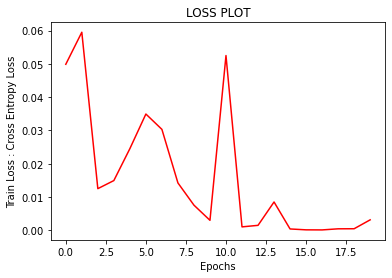

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


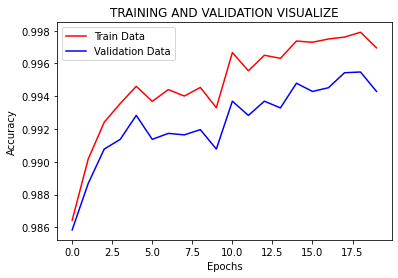

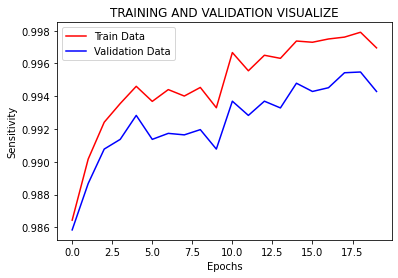

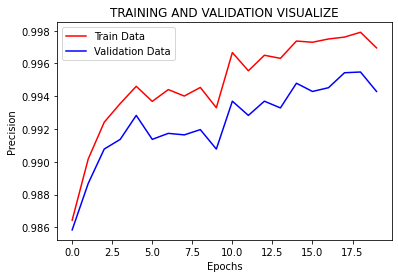

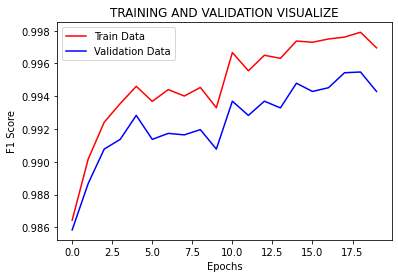

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




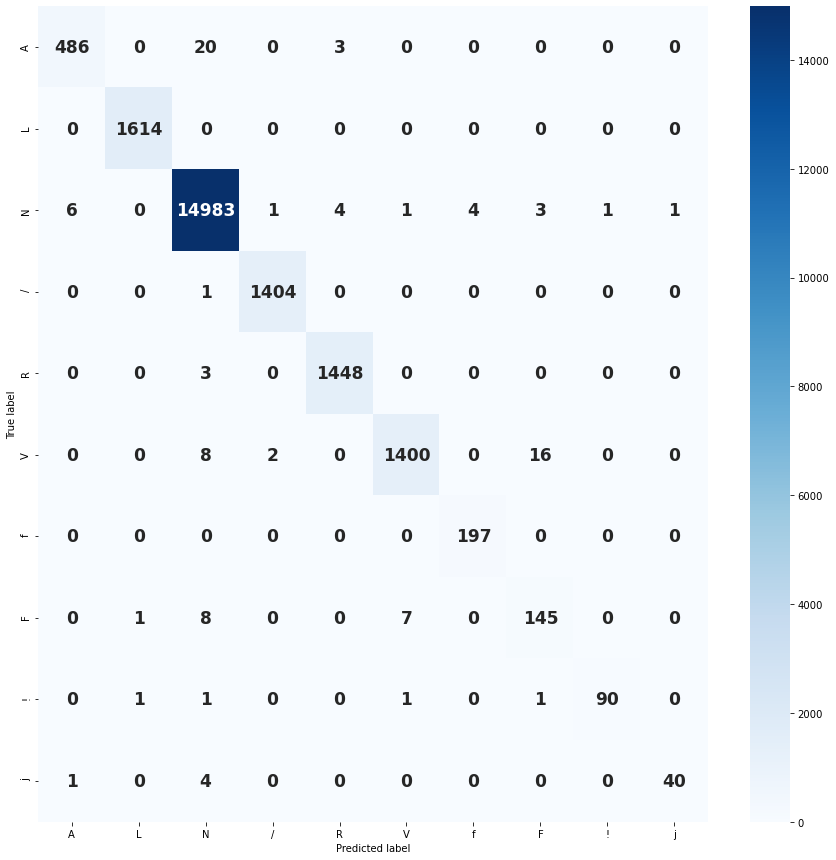



Metrics




precision    recall  f1-score  Accuracy
A     0.985801  0.954813  0.970060  0.998631
L     0.998762  1.000000  0.999381  0.999909
N     0.997006  0.998600  0.997802  0.996987
/     0.997868  0.999288  0.998578  0.999817
R     0.995189  0.997932  0.996559  0.999544
V     0.993612  0.981767  0.987654  0.998402
f     0.980100  1.000000  0.989950  0.999817
F     0.878788  0.900621  0.889571  0.998357
!     0.989011  0.957447  0.972973  0.999772
j     0.975610  0.888889  0.930233  0.999726
all   0.995481  0.995481  0.995481  0.995481

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




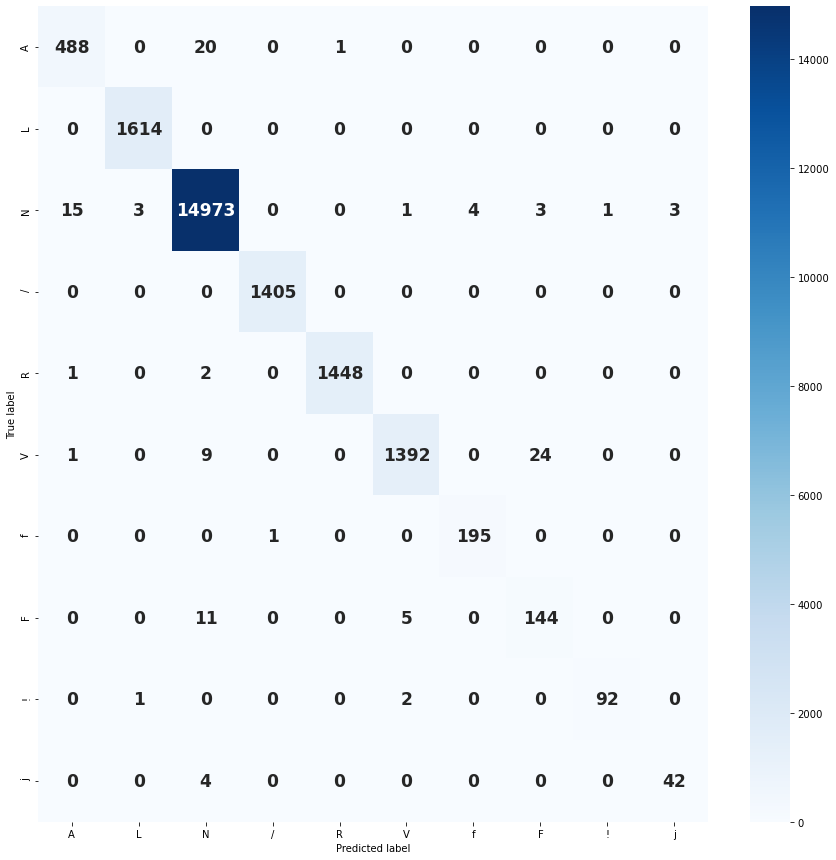



Metrics




precision    recall  f1-score  Accuracy
A     0.966337  0.958743  0.962525  0.998265
L     0.997528  1.000000  0.998762  0.999817
N     0.996937  0.998000  0.997469  0.996530
/     0.999289  1.000000  0.999644  0.999954
R     0.999310  0.997932  0.998621  0.999817
V     0.994286  0.976157  0.985138  0.998083
f     0.979899  0.994898  0.987342  0.999772
F     0.842105  0.900000  0.870091  0.998037
!     0.989247  0.968421  0.978723  0.999817
j     0.933333  0.913043  0.923077  0.999680
all   0.994887  0.994887  0.994887  0.994887

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [43]:
best_val_model = ultimate_trainer(trainData=TRAIN[10],valData=VAL[10],testData=TEST[10],epochs=20,config=CONFIG[10],n_number=10,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 15 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-40-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.2528324127197266
+-> Min Training Loss : 2.227146863937378
+-> Min Training Loss : 2.0779476165771484
+-> Min Training Loss : 1.9560683965682983
+-> Min Training Loss : 1.925127625465393
+-> Min Training Loss : 1.8991973400115967
+-> Min Training Loss : 1.6457269191741943
+-> Min Training Loss : 1.6263331174850464
+-> Min Training Loss : 1.5416299104690552
+-> Min Training Loss : 1.461054801940918
+-> Min Training Loss : 1.3720262050628662
+-> Min Training Loss : 1.3338181972503662
+-> Min Training Loss : 1.3093857765197754
+-> Min Training Loss : 1.2258613109588623
+-> Min Training Loss : 1.2061495780944824
+-> Min Training Loss : 1.1701748371124268
+-> Min Training Loss : 1.0525155067443848
+-> Min Training Loss : 0.9034761190414429
+-> Min Training Loss : 0.8598300218582153
+-> Min Training Loss : 0.7239500880241394
+-> Min Training Loss : 0.6864233613014221
+-> Min Training Loss : 0.6662647724151611
+-> Min Training Loss : 0.5789481401443481
+-> Min Traini

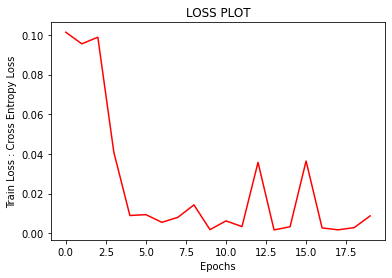

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


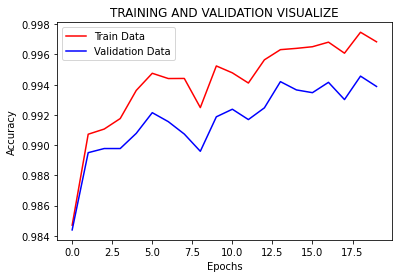

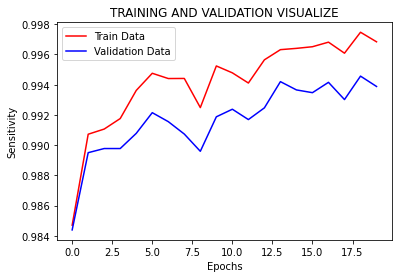

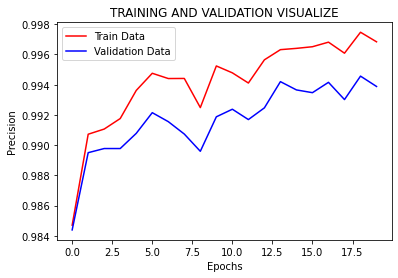

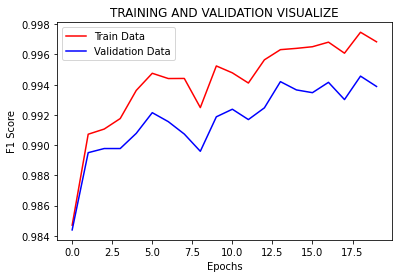

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




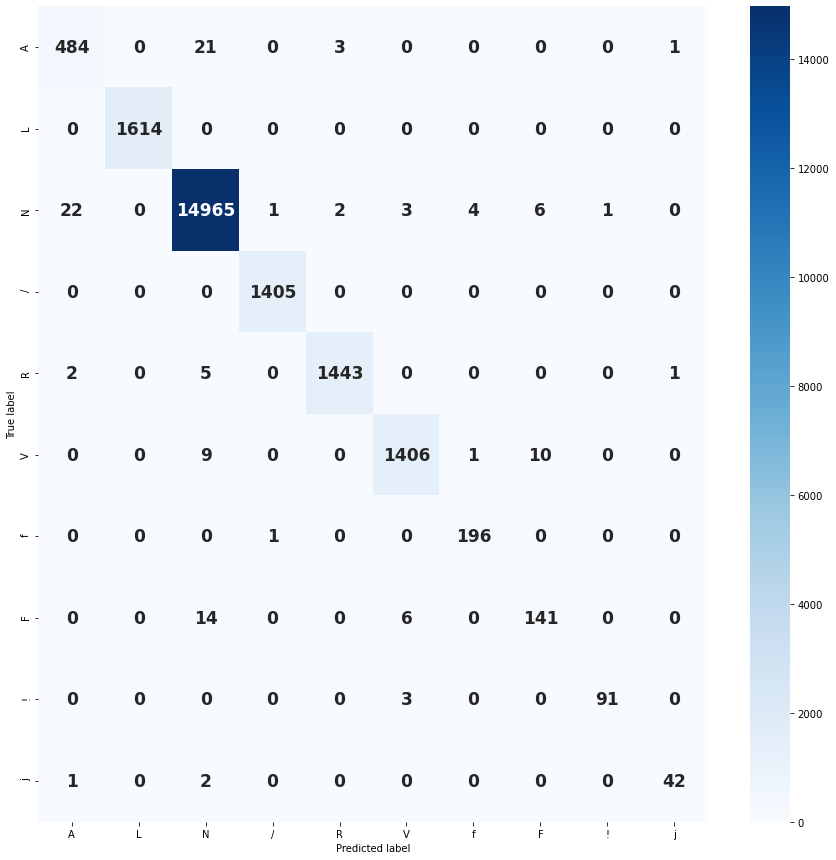



Metrics




precision    recall  f1-score  Accuracy
A     0.950884  0.950884  0.950884  0.997718
L     1.000000  1.000000  1.000000  1.000000
N     0.996604  0.997401  0.997002  0.995892
/     0.998579  1.000000  0.999289  0.999909
R     0.996547  0.994487  0.995516  0.999407
V     0.991537  0.985975  0.988748  0.998539
f     0.975124  0.994924  0.984925  0.999726
F     0.898089  0.875776  0.886792  0.998357
!     0.989130  0.968085  0.978495  0.999817
j     0.954545  0.933333  0.943820  0.999772
all   0.994568  0.994568  0.994568  0.994568

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




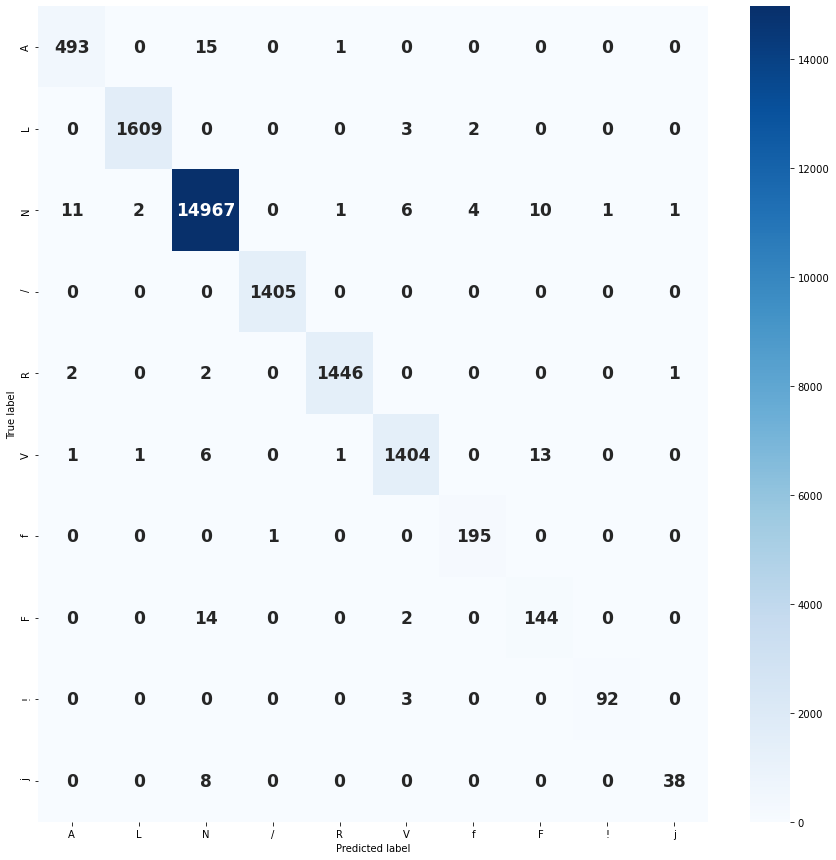



Metrics




precision    recall  f1-score  Accuracy
A     0.972387  0.968566  0.970472  0.998630
L     0.998139  0.996902  0.997520  0.999635
N     0.997002  0.997600  0.997301  0.996302
/     0.999289  1.000000  0.999644  0.999954
R     0.997930  0.996554  0.997241  0.999635
V     0.990127  0.984572  0.987342  0.998357
f     0.970149  0.994898  0.982368  0.999680
F     0.862275  0.900000  0.880734  0.998220
!     0.989247  0.968421  0.978723  0.999817
j     0.950000  0.826087  0.883721  0.999543
all   0.994887  0.994887  0.994887  0.994887

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [44]:
best_val_model = ultimate_trainer(trainData=TRAIN[15],valData=VAL[15],testData=TEST[15],epochs=20,config=CONFIG[15],n_number=15,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 20 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-40-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.5149362087249756
+-> Min Training Loss : 2.441563367843628
+-> Min Training Loss : 2.34137225151062
+-> Min Training Loss : 2.226503849029541
+-> Min Training Loss : 2.191612720489502
+-> Min Training Loss : 1.8638235330581665
+-> Min Training Loss : 1.8085589408874512
+-> Min Training Loss : 1.8012008666992188
+-> Min Training Loss : 1.6856051683425903
+-> Min Training Loss : 1.5866820812225342
+-> Min Training Loss : 1.5683690309524536
+-> Min Training Loss : 1.45353102684021
+-> Min Training Loss : 1.4210563898086548
+-> Min Training Loss : 1.4167455434799194
+-> Min Training Loss : 1.365401268005371
+-> Min Training Loss : 1.0991398096084595
+-> Min Training Loss : 1.0932265520095825
+-> Min Training Loss : 1.0385395288467407
+-> Min Training Loss : 0.8490023016929626
+-> Min Training Loss : 0.7788994312286377
+-> Min Training Loss : 0.7403136491775513
+-> Min Training Loss : 0.6875097155570984
+-> Min Training Loss : 0.6203845143318176
+-> Min Training Lo

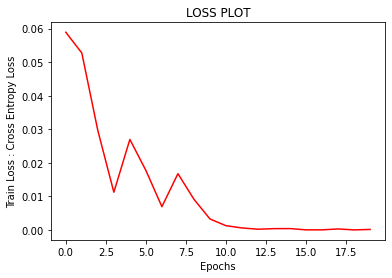

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


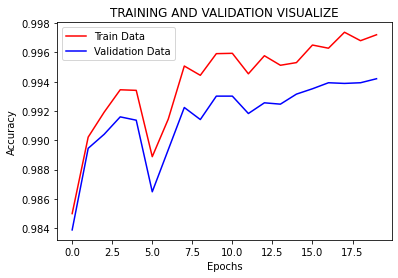

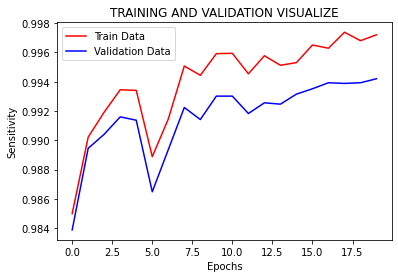

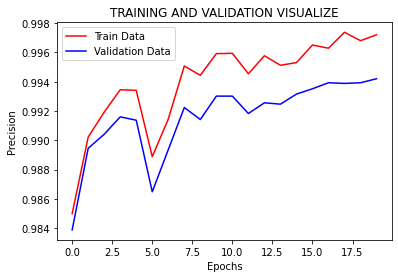

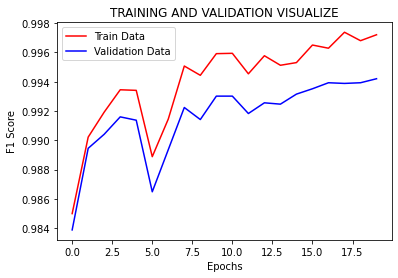

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




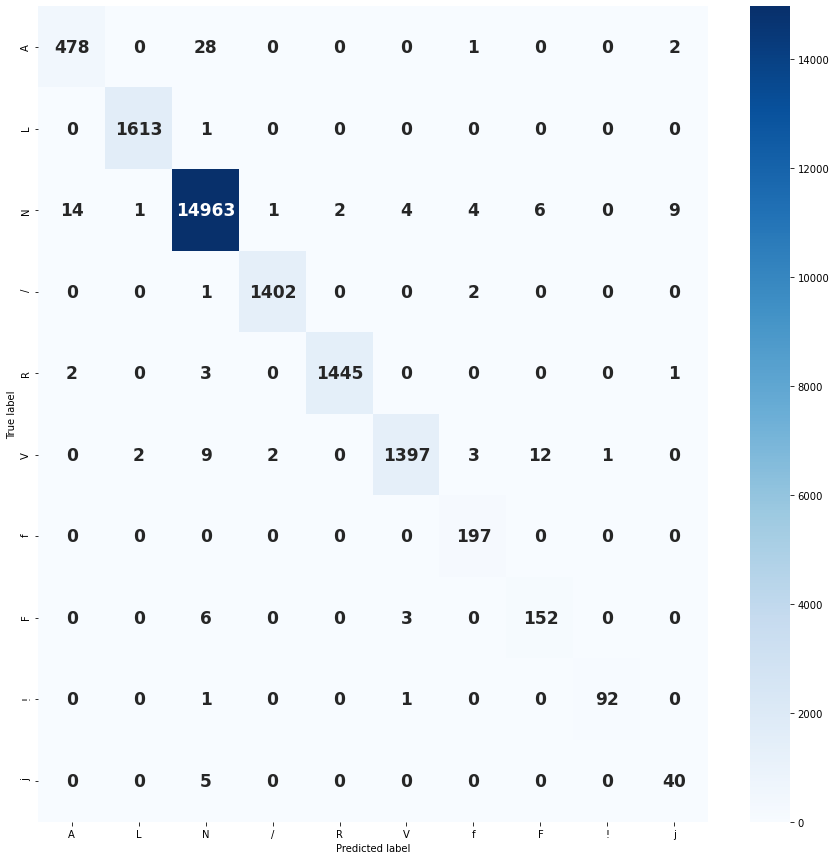



Metrics




precision    recall  f1-score  Accuracy
A     0.967611  0.939096  0.953141  0.997854
L     0.998144  0.999380  0.998762  0.999817
N     0.996404  0.997267  0.996836  0.995663
/     0.997865  0.997865  0.997865  0.999726
R     0.998618  0.995865  0.997239  0.999635
V     0.994306  0.979663  0.986930  0.998311
f     0.951691  1.000000  0.975248  0.999544
F     0.894118  0.944099  0.918429  0.998767
!     0.989247  0.978723  0.983957  0.999863
j     0.769231  0.888889  0.824742  0.999224
all   0.994203  0.994203  0.994203  0.994203

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




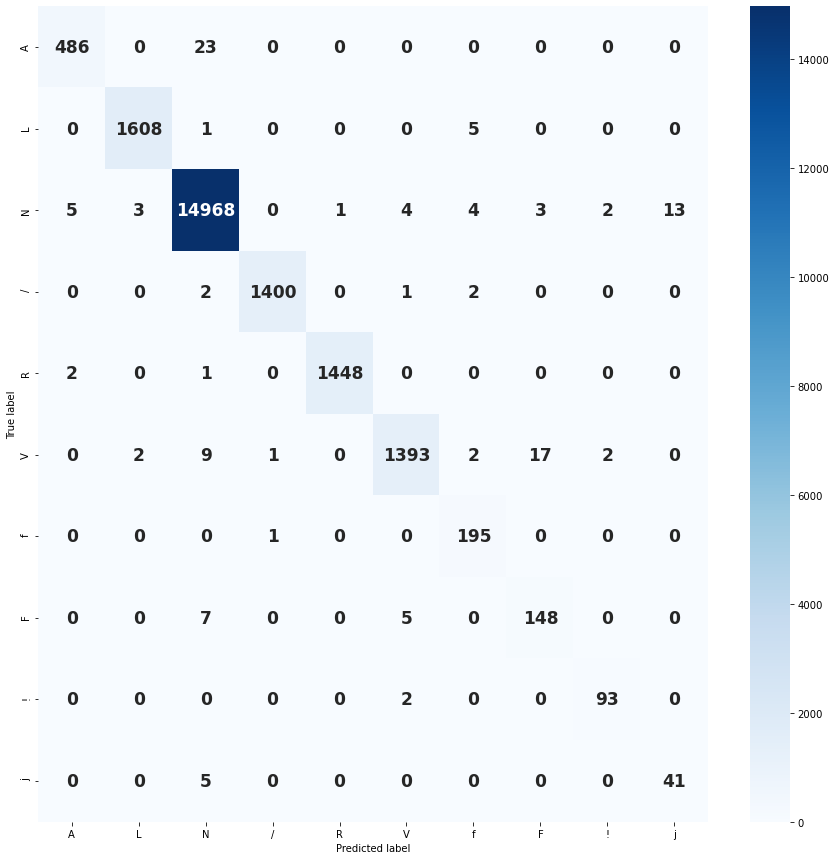



Metrics




precision    recall  f1-score  Accuracy
A     0.985801  0.954813  0.970060  0.998630
L     0.996900  0.996283  0.996591  0.999498
N     0.996803  0.997667  0.997235  0.996211
/     0.998573  0.996441  0.997506  0.999680
R     0.999310  0.997932  0.998621  0.999817
V     0.991459  0.976858  0.984105  0.997946
f     0.937500  0.994898  0.965347  0.999361
F     0.880952  0.925000  0.902439  0.998539
!     0.958763  0.978947  0.968750  0.999726
j     0.759259  0.891304  0.820000  0.999178
all   0.994294  0.994294  0.994294  0.994294

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [45]:
best_val_model = ultimate_trainer(trainData=TRAIN[20],valData=VAL[20],testData=TEST[20],epochs=20,config=CONFIG[20],n_number=20,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 25 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-40-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.58144211769104
+-> Min Training Loss : 2.4360623359680176
+-> Min Training Loss : 2.3231945037841797
+-> Min Training Loss : 2.1946213245391846
+-> Min Training Loss : 2.0332093238830566
+-> Min Training Loss : 1.7065457105636597
+-> Min Training Loss : 1.652779459953308
+-> Min Training Loss : 1.4875457286834717
+-> Min Training Loss : 1.4096264839172363
+-> Min Training Loss : 1.4094916582107544
+-> Min Training Loss : 1.2126898765563965
+-> Min Training Loss : 1.1726206541061401
+-> Min Training Loss : 1.1214842796325684
+-> Min Training Loss : 1.1202127933502197
+-> Min Training Loss : 1.0876439809799194
+-> Min Training Loss : 1.078853964805603
+-> Min Training Loss : 0.8677555322647095
+-> Min Training Loss : 0.7633031010627747
+-> Min Training Loss : 0.6992880702018738
+-> Min Training Loss : 0.6661249995231628
+-> Min Training Loss : 0.6453253626823425
+-> Min Training Loss : 0.5703316330909729
+-> Min Training Loss : 0.5343469977378845
+-> Min Trainin

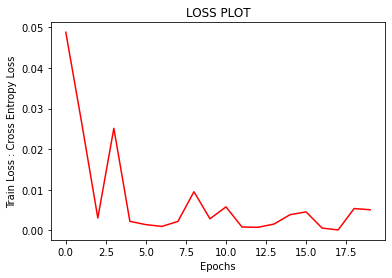

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


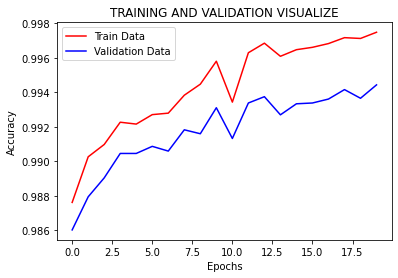

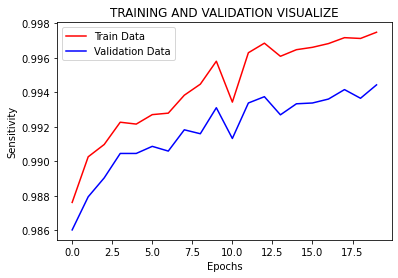

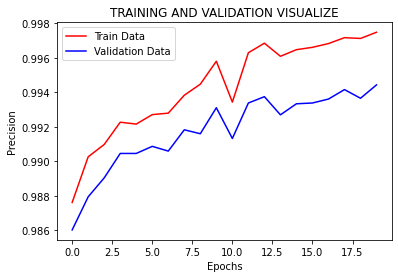

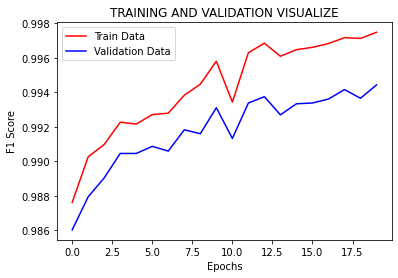

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




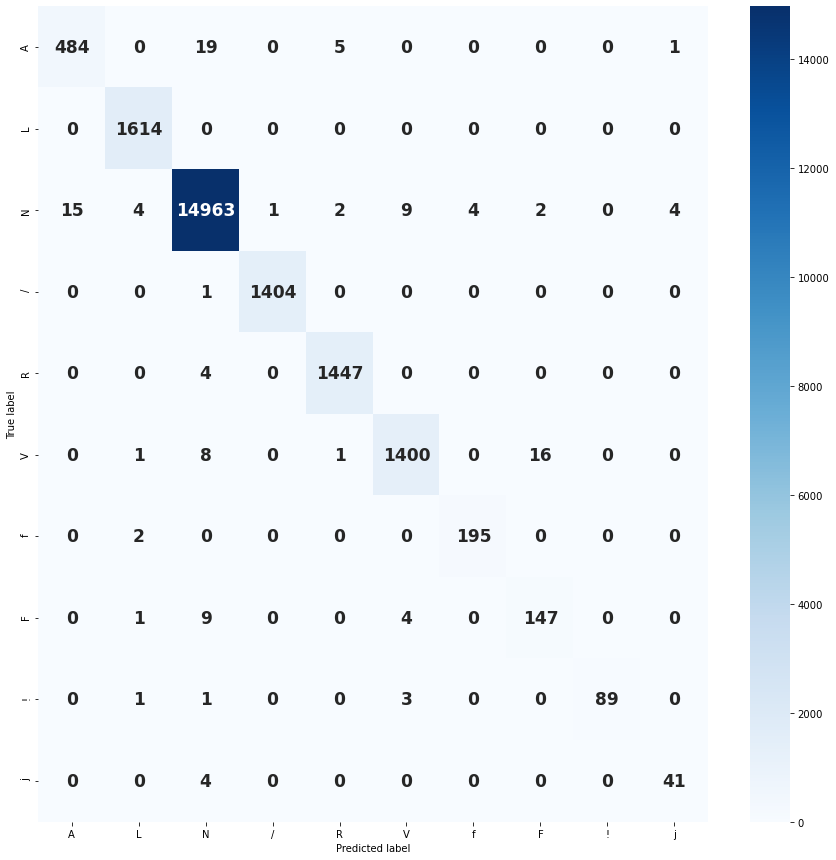



Metrics




precision    recall  f1-score  Accuracy
A     0.969940  0.950884  0.960317  0.998174
L     0.994455  1.000000  0.997220  0.999589
N     0.996935  0.997267  0.997101  0.996028
/     0.999288  0.999288  0.999288  0.999909
R     0.994502  0.997243  0.995871  0.999452
V     0.988701  0.981767  0.985222  0.998083
f     0.979899  0.989848  0.984848  0.999726
F     0.890909  0.913043  0.901840  0.998539
!     1.000000  0.946809  0.972678  0.999772
j     0.891304  0.911111  0.901099  0.999589
all   0.994431  0.994431  0.994431  0.994431

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




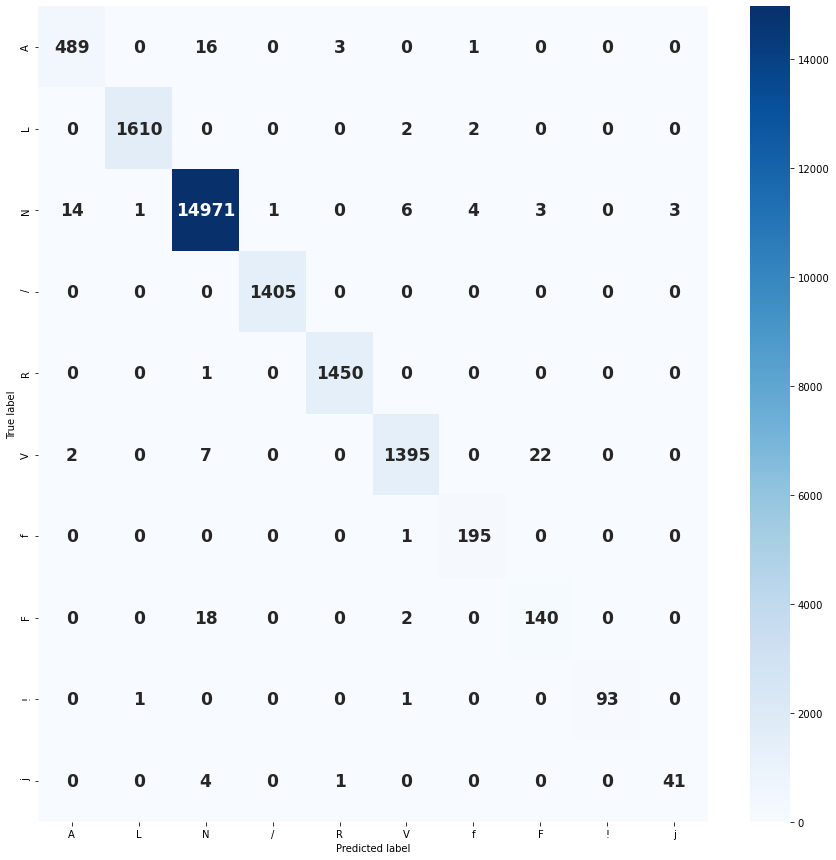



Metrics




precision    recall  f1-score  Accuracy
A     0.968317  0.960707  0.964497  0.998357
L     0.998759  0.997522  0.998140  0.999726
N     0.996937  0.997867  0.997402  0.996439
/     0.999289  1.000000  0.999644  0.999954
R     0.997249  0.999311  0.998279  0.999772
V     0.991471  0.978261  0.984822  0.998037
f     0.965347  0.994898  0.979899  0.999635
F     0.848485  0.875000  0.861538  0.997946
!     1.000000  0.978947  0.989362  0.999909
j     0.931818  0.891304  0.911111  0.999635
all   0.994704  0.994704  0.994704  0.994704

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [46]:
best_val_model = ultimate_trainer(trainData=TRAIN[25],valData=VAL[25],testData=TEST[25],epochs=20,config=CONFIG[25],n_number=25,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 30 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-40-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.1220805644989014
+-> Min Training Loss : 2.0684361457824707
+-> Min Training Loss : 1.951672077178955
+-> Min Training Loss : 1.9350407123565674
+-> Min Training Loss : 1.8232378959655762
+-> Min Training Loss : 1.7781565189361572
+-> Min Training Loss : 1.5435094833374023
+-> Min Training Loss : 1.4415431022644043
+-> Min Training Loss : 1.311277985572815
+-> Min Training Loss : 1.2397253513336182
+-> Min Training Loss : 1.1949666738510132
+-> Min Training Loss : 1.1225850582122803
+-> Min Training Loss : 1.074326515197754
+-> Min Training Loss : 1.064959168434143
+-> Min Training Loss : 1.0618618726730347
+-> Min Training Loss : 0.9837495684623718
+-> Min Training Loss : 0.9712071418762207
+-> Min Training Loss : 0.8813729286193848
+-> Min Training Loss : 0.8541052341461182
+-> Min Training Loss : 0.7491490840911865
+-> Min Training Loss : 0.6095827221870422
+-> Min Training Loss : 0.5708891749382019
+-> Min Training Loss : 0.5519357919692993
+-> Min Trainin

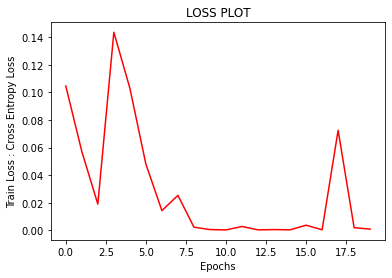

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


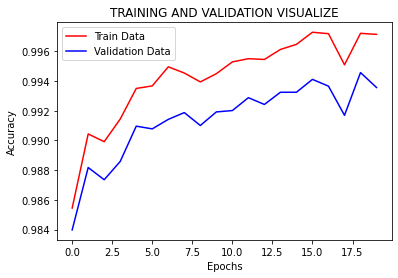

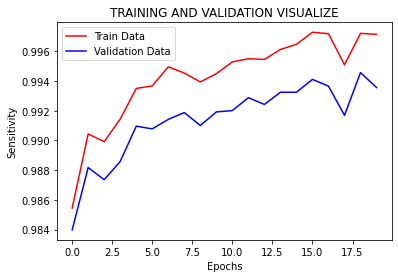

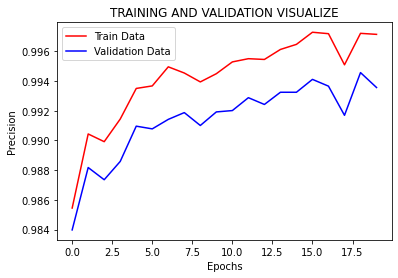

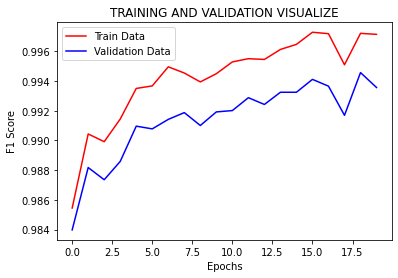

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




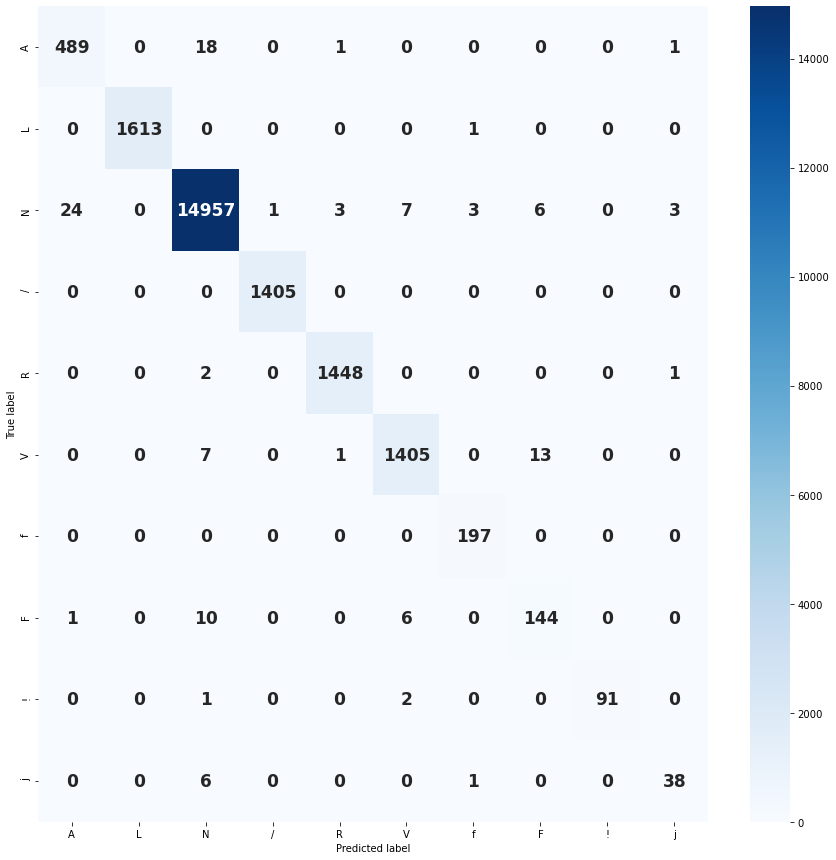



Metrics




precision    recall  f1-score  Accuracy
A     0.951362  0.960707  0.956012  0.997946
L     1.000000  0.999380  0.999690  0.999954
N     0.997067  0.996868  0.996967  0.995846
/     0.999289  1.000000  0.999644  0.999954
R     0.996559  0.997932  0.997245  0.999635
V     0.989437  0.985273  0.987351  0.998357
f     0.975248  1.000000  0.987469  0.999772
F     0.883436  0.894410  0.888889  0.998357
!     1.000000  0.968085  0.983784  0.999863
j     0.883721  0.844444  0.863636  0.999452
all   0.994568  0.994568  0.994568  0.994568

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




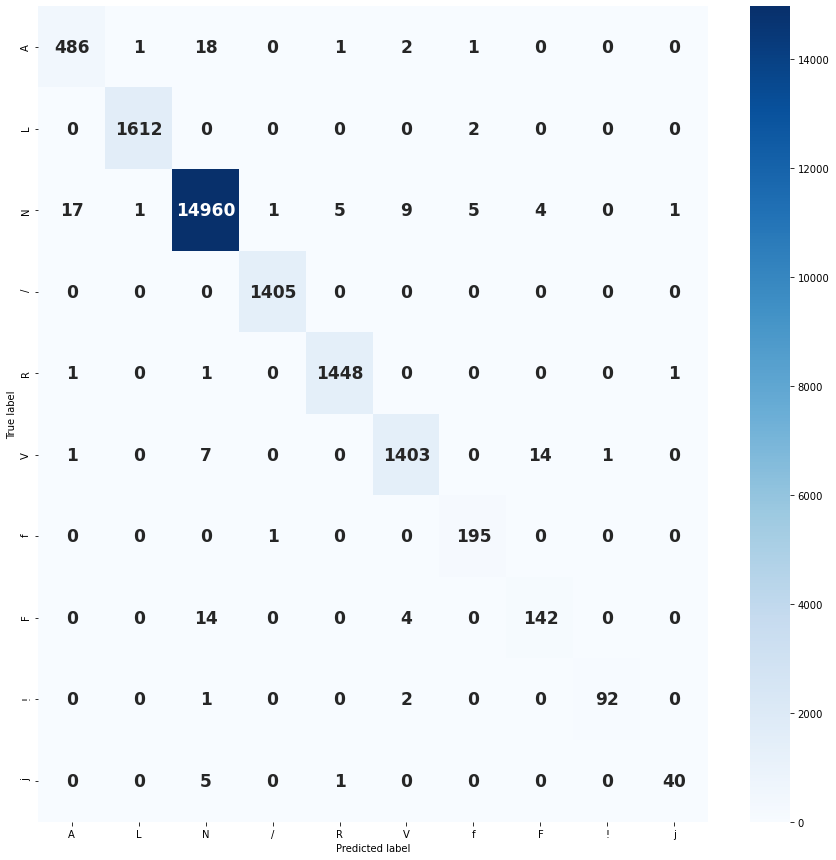



Metrics




precision    recall  f1-score  Accuracy
A     0.962376  0.954813  0.958580  0.998083
L     0.998761  0.998761  0.998761  0.999817
N     0.996935  0.997134  0.997034  0.995937
/     0.998579  1.000000  0.999289  0.999909
R     0.995189  0.997932  0.996559  0.999543
V     0.988028  0.983871  0.985945  0.998174
f     0.960591  0.994898  0.977444  0.999589
F     0.887500  0.887500  0.887500  0.998357
!     0.989247  0.968421  0.978723  0.999817
j     0.952381  0.869565  0.909091  0.999635
all   0.994430  0.994430  0.994430  0.994430

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [47]:
best_val_model = ultimate_trainer(trainData=TRAIN[30],valData=VAL[30],testData=TEST[30],epochs=20,config=CONFIG[30],n_number=30,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 35 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-40-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.4675662517547607
+-> Min Training Loss : 2.261939525604248
+-> Min Training Loss : 2.1539359092712402
+-> Min Training Loss : 2.029167890548706
+-> Min Training Loss : 1.8825509548187256
+-> Min Training Loss : 1.7974885702133179
+-> Min Training Loss : 1.6599255800247192
+-> Min Training Loss : 1.6323238611221313
+-> Min Training Loss : 1.5901676416397095
+-> Min Training Loss : 1.5633172988891602
+-> Min Training Loss : 1.513127088546753
+-> Min Training Loss : 1.4282362461090088
+-> Min Training Loss : 1.406943678855896
+-> Min Training Loss : 1.382912039756775
+-> Min Training Loss : 1.2341535091400146
+-> Min Training Loss : 1.2176158428192139
+-> Min Training Loss : 1.14628005027771
+-> Min Training Loss : 0.9564046263694763
+-> Min Training Loss : 0.9331828951835632
+-> Min Training Loss : 0.9277611970901489
+-> Min Training Loss : 0.8155046105384827
+-> Min Training Loss : 0.6822130084037781
+-> Min Training Loss : 0.6093612313270569
+-> Min Training L

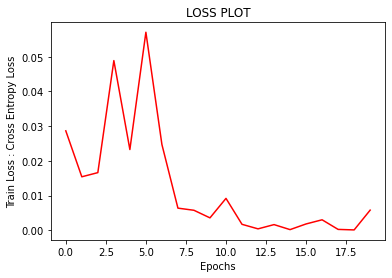

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


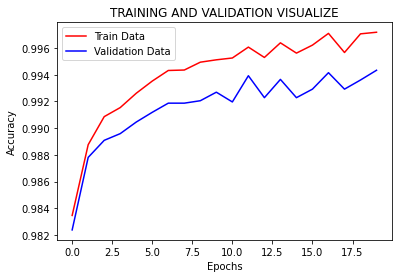

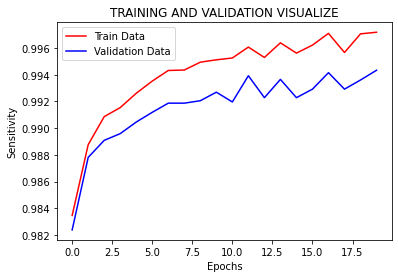

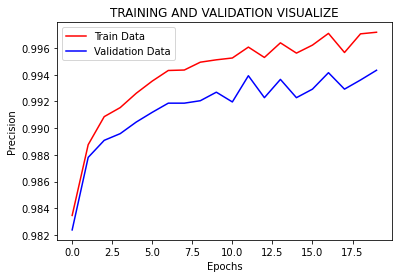

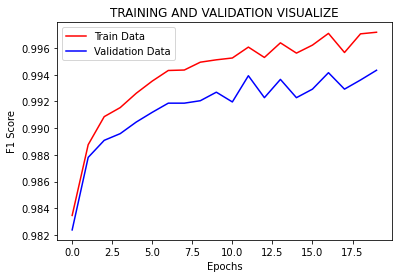

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




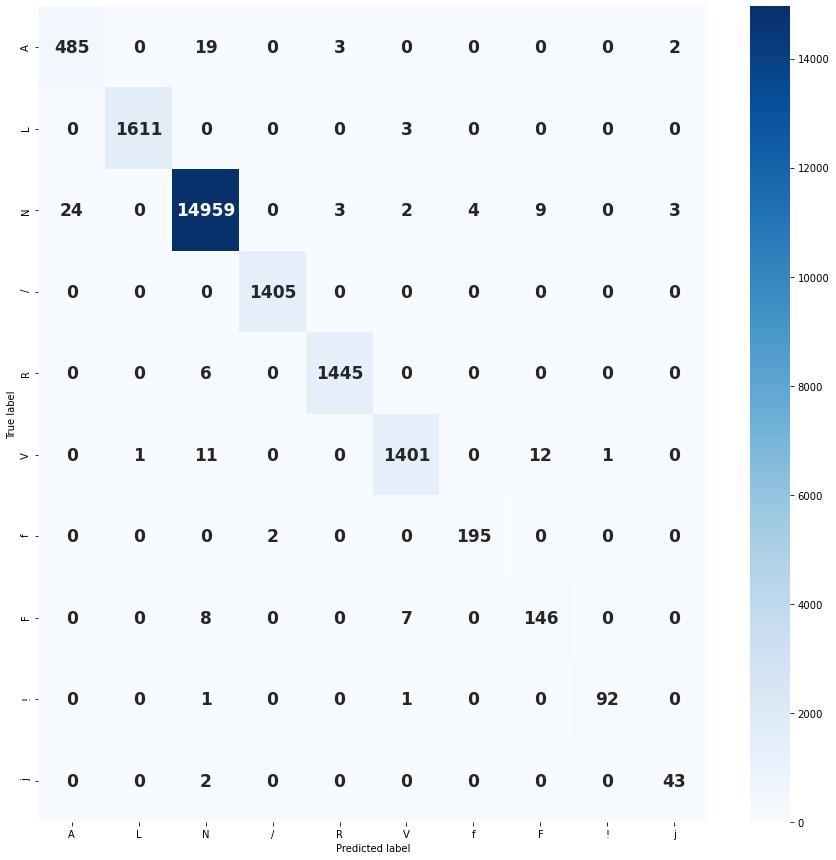



Metrics




precision    recall  f1-score  Accuracy
A     0.952849  0.952849  0.952849  0.997809
L     0.999380  0.998141  0.998760  0.999817
N     0.996868  0.997001  0.996934  0.995800
/     0.998579  1.000000  0.999289  0.999909
R     0.995865  0.995865  0.995865  0.999452
V     0.990806  0.982468  0.986620  0.998265
f     0.979899  0.989848  0.984848  0.999726
F     0.874251  0.906832  0.890244  0.998357
!     0.989247  0.978723  0.983957  0.999863
j     0.895833  0.955556  0.924731  0.999680
all   0.994339  0.994339  0.994339  0.994339

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




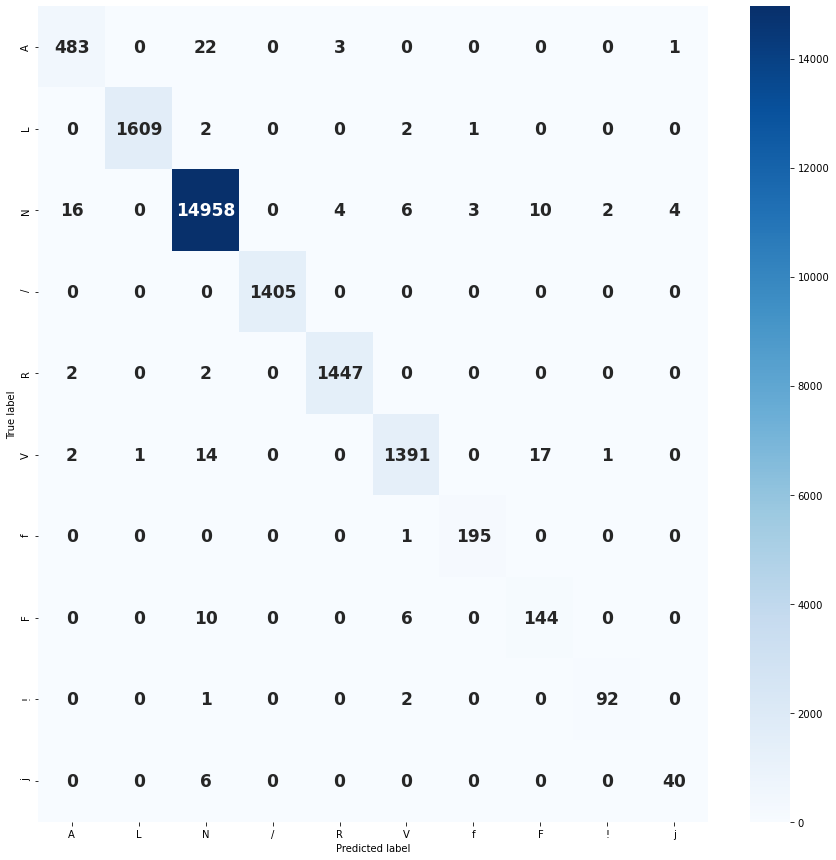



Metrics




precision    recall  f1-score  Accuracy
A     0.960239  0.948919  0.954545  0.997900
L     0.999379  0.996902  0.998139  0.999726
N     0.996204  0.997001  0.996602  0.995344
/     1.000000  1.000000  1.000000  1.000000
R     0.995186  0.997243  0.996213  0.999498
V     0.987926  0.975456  0.981651  0.997626
f     0.979899  0.994898  0.987342  0.999772
F     0.842105  0.900000  0.870091  0.998037
!     0.968421  0.968421  0.968421  0.999726
j     0.888889  0.869565  0.879121  0.999498
all   0.993563  0.993563  0.993563  0.993563

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [48]:
p = 35
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 40 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-40-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.7745087146759033
+-> Min Training Loss : 2.6335947513580322
+-> Min Training Loss : 2.6189687252044678
+-> Min Training Loss : 2.501068353652954
+-> Min Training Loss : 2.452592611312866
+-> Min Training Loss : 2.4467878341674805
+-> Min Training Loss : 2.435936450958252
+-> Min Training Loss : 2.334426164627075
+-> Min Training Loss : 1.9970041513442993
+-> Min Training Loss : 1.8383439779281616
+-> Min Training Loss : 1.7800770998001099
+-> Min Training Loss : 1.6750760078430176
+-> Min Training Loss : 1.6445540189743042
+-> Min Training Loss : 1.3987315893173218
+-> Min Training Loss : 1.374159574508667
+-> Min Training Loss : 1.3307969570159912
+-> Min Training Loss : 1.283233404159546
+-> Min Training Loss : 1.1833868026733398
+-> Min Training Loss : 1.073505163192749
+-> Min Training Loss : 1.0726054906845093
+-> Min Training Loss : 0.9537554383277893
+-> Min Training Loss : 0.9123837351799011
+-> Min Training Loss : 0.8498028516769409
+-> Min Training L

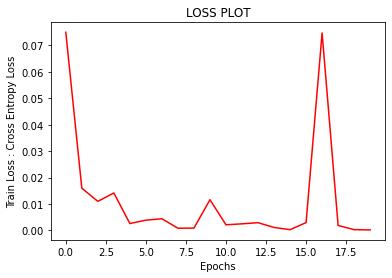

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


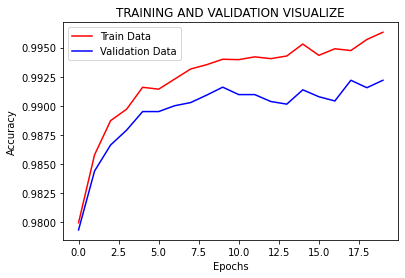

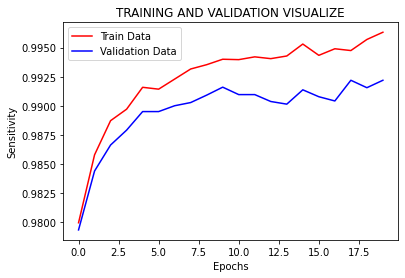

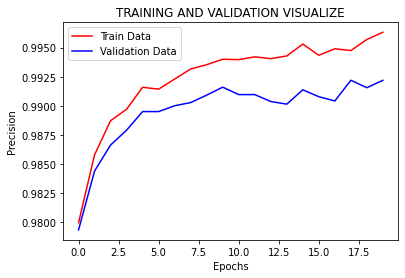

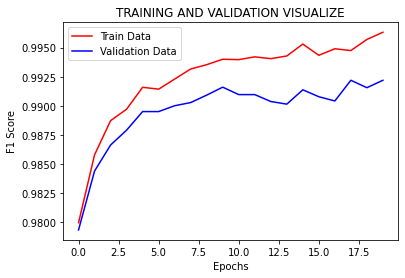

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




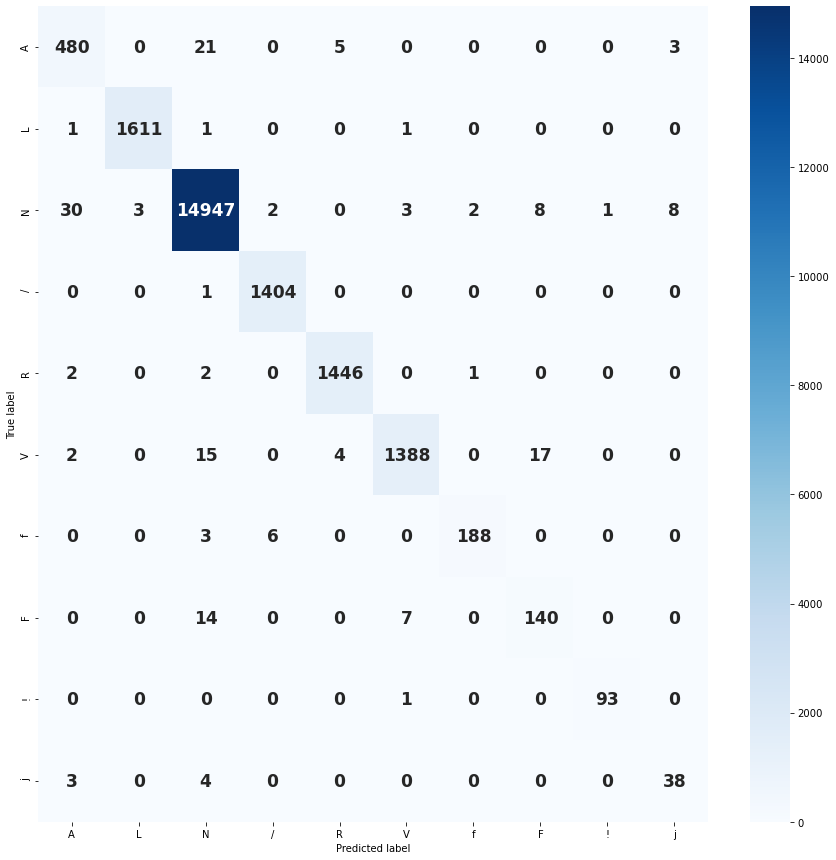



Metrics




precision    recall  f1-score  Accuracy
A     0.926641  0.943026  0.934761  0.996941
L     0.998141  0.998141  0.998141  0.999726
N     0.995936  0.996201  0.996068  0.994613
/     0.994334  0.999288  0.996805  0.999589
R     0.993814  0.996554  0.995182  0.999361
V     0.991429  0.973352  0.982307  0.997718
f     0.984293  0.954315  0.969072  0.999452
F     0.848485  0.869565  0.858896  0.997900
!     0.989362  0.989362  0.989362  0.999909
j     0.775510  0.844444  0.808511  0.999178
all   0.992194  0.992194  0.992194  0.992194

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




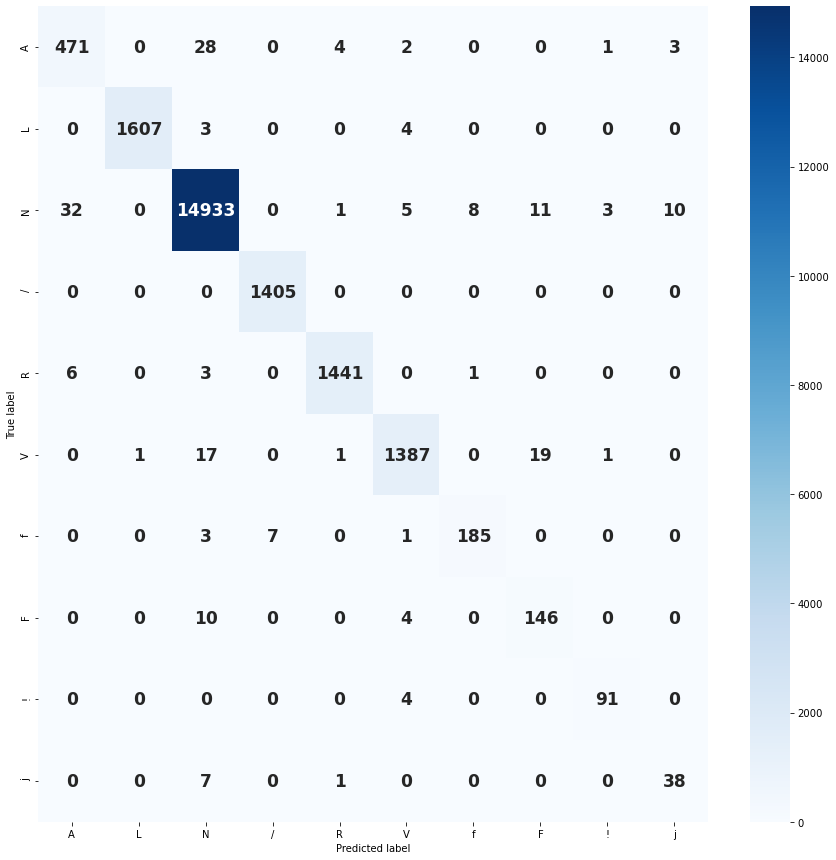



Metrics




precision    recall  f1-score  Accuracy
A     0.925344  0.925344  0.925344  0.996530
L     0.999378  0.995663  0.997517  0.999635
N     0.995268  0.995334  0.995301  0.993563
/     0.995042  1.000000  0.997515  0.999680
R     0.995166  0.993108  0.994136  0.999224
V     0.985785  0.972651  0.979174  0.997307
f     0.953608  0.943878  0.948718  0.999087
F     0.829545  0.912500  0.869048  0.997991
!     0.947917  0.957895  0.952880  0.999589
j     0.745098  0.826087  0.783505  0.999041
all   0.990824  0.990824  0.990824  0.990824

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [49]:
p = 40
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 45 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-40-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.2860560417175293
+-> Min Training Loss : 2.2468574047088623
+-> Min Training Loss : 2.1945276260375977
+-> Min Training Loss : 2.163196086883545
+-> Min Training Loss : 2.113259792327881
+-> Min Training Loss : 2.075355052947998
+-> Min Training Loss : 2.055846929550171
+-> Min Training Loss : 1.9911636114120483
+-> Min Training Loss : 1.8644487857818604
+-> Min Training Loss : 1.8290919065475464
+-> Min Training Loss : 1.8127753734588623
+-> Min Training Loss : 1.7863004207611084
+-> Min Training Loss : 1.7725437879562378
+-> Min Training Loss : 1.7234867811203003
+-> Min Training Loss : 1.610625982284546
+-> Min Training Loss : 1.5686813592910767
+-> Min Training Loss : 1.4137402772903442
+-> Min Training Loss : 1.4083771705627441
+-> Min Training Loss : 1.3903154134750366
+-> Min Training Loss : 1.3732823133468628
+-> Min Training Loss : 1.2928448915481567
+-> Min Training Loss : 1.2887787818908691
+-> Min Training Loss : 1.1405034065246582
+-> Min Training

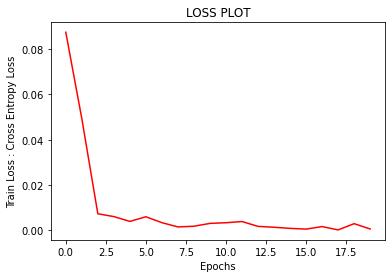

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


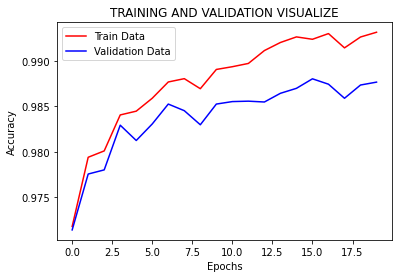

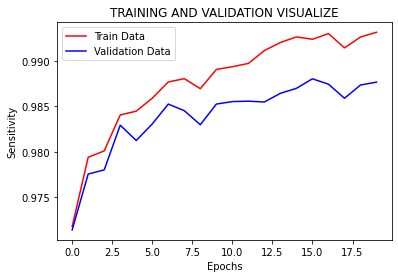

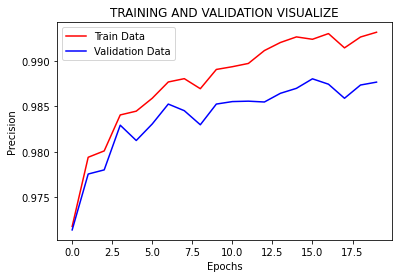

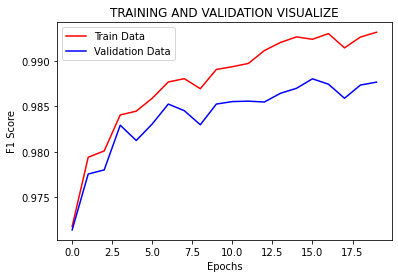

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




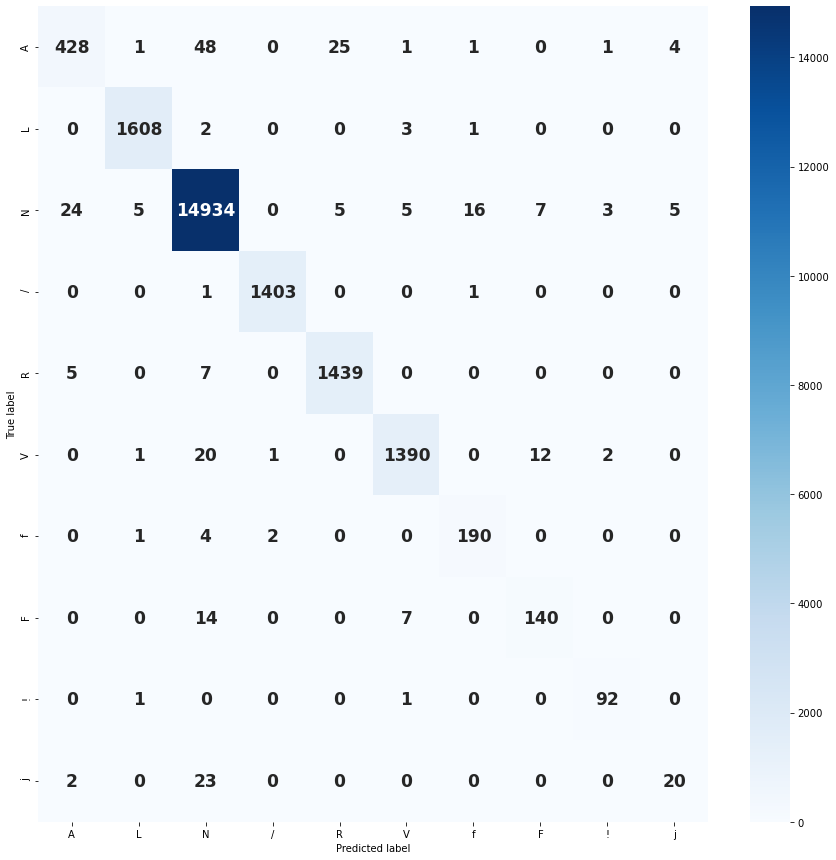



Metrics




precision    recall  f1-score  Accuracy
A     0.932462  0.840864  0.884298  0.994887
L     0.994434  0.996283  0.995357  0.999315
N     0.992095  0.995335  0.993712  0.991372
/     0.997866  0.998577  0.998221  0.999772
R     0.979578  0.991730  0.985616  0.998083
V     0.987918  0.974755  0.981292  0.997581
f     0.909091  0.964467  0.935961  0.998813
F     0.880503  0.869565  0.875000  0.998174
!     0.938776  0.978723  0.958333  0.999635
j     0.689655  0.444444  0.540541  0.998448
all   0.988040  0.988040  0.988040  0.988040

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




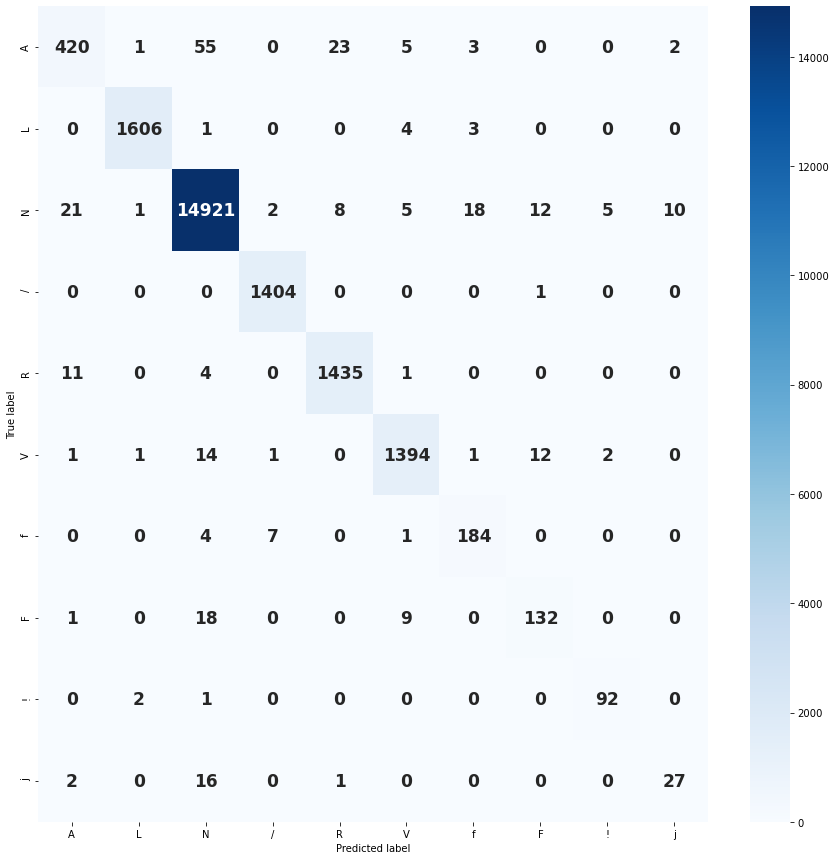



Metrics




precision    recall  f1-score  Accuracy
A     0.921053  0.825147  0.870466  0.994294
L     0.996896  0.995043  0.995969  0.999407
N     0.992484  0.994534  0.993508  0.991098
/     0.992928  0.999288  0.996098  0.999498
R     0.978187  0.988973  0.983550  0.997809
V     0.982382  0.977560  0.979965  0.997398
f     0.880383  0.938776  0.908642  0.998311
F     0.840764  0.825000  0.832808  0.997580
!     0.929293  0.968421  0.948454  0.999543
j     0.692308  0.586957  0.635294  0.998585
all   0.986761  0.986761  0.986761  0.986761

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [50]:
p = 45
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 50 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-40-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.427433490753174
+-> Min Training Loss : 2.358253002166748
+-> Min Training Loss : 2.223234176635742
+-> Min Training Loss : 2.2213261127471924
+-> Min Training Loss : 2.2018890380859375
+-> Min Training Loss : 2.05749249458313
+-> Min Training Loss : 1.9161168336868286
+-> Min Training Loss : 1.9110339879989624
+-> Min Training Loss : 1.8354406356811523
+-> Min Training Loss : 1.7169984579086304
+-> Min Training Loss : 1.7054166793823242
+-> Min Training Loss : 1.6246107816696167
+-> Min Training Loss : 1.5407031774520874
+-> Min Training Loss : 1.51526939868927
+-> Min Training Loss : 1.4600560665130615
+-> Min Training Loss : 1.4543761014938354
+-> Min Training Loss : 1.4250057935714722
+-> Min Training Loss : 1.282921314239502
+-> Min Training Loss : 1.2368872165679932
+-> Min Training Loss : 1.0959725379943848
+-> Min Training Loss : 1.0402612686157227
+-> Min Training Loss : 0.9464765787124634
+-> Min Training Loss : 0.8899227380752563
+-> Min Training Lo

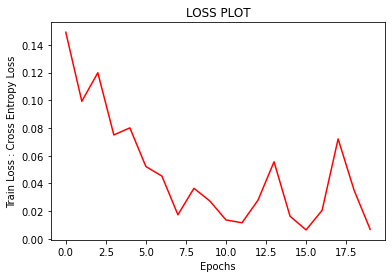

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


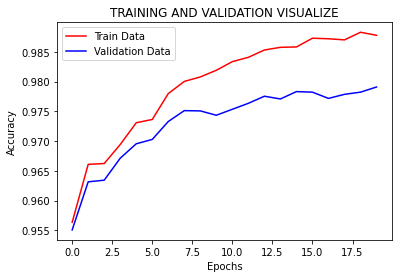

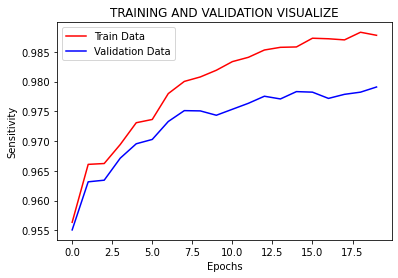

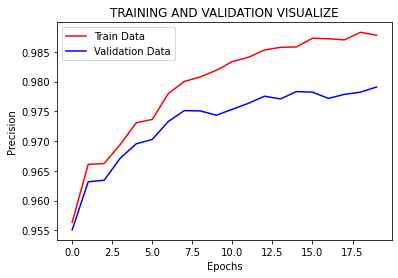

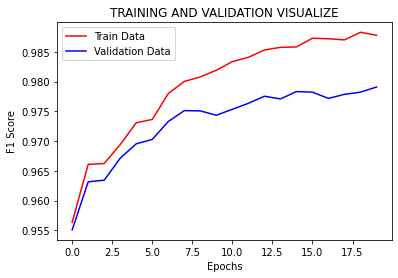

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




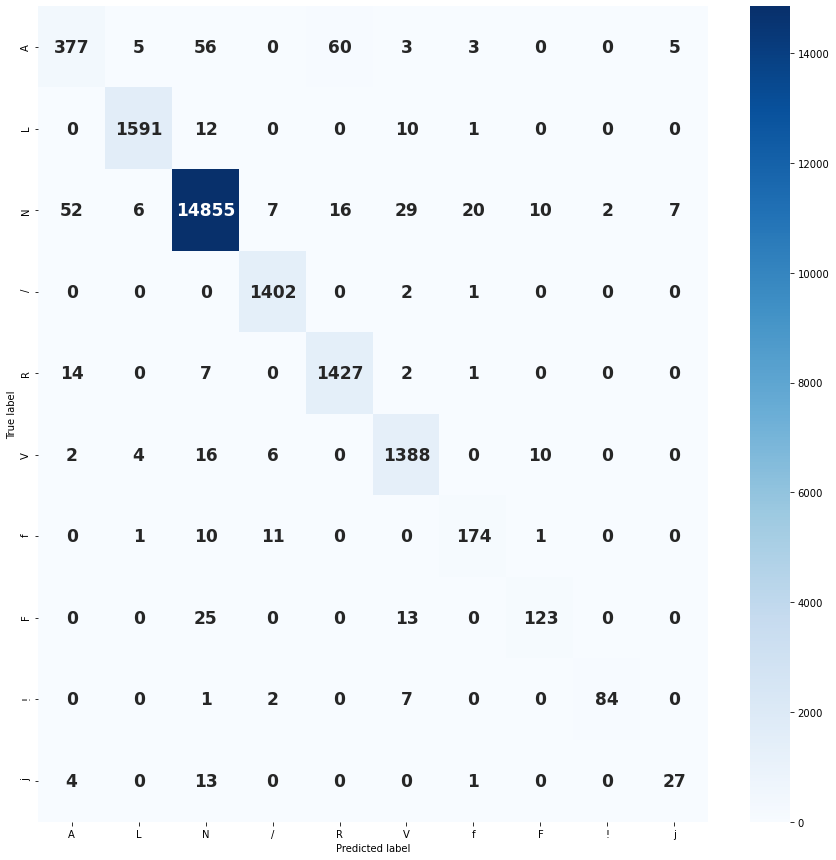



Metrics




precision    recall  f1-score  Accuracy
A     0.839644  0.740668  0.787056  0.990687
L     0.990044  0.985750  0.987892  0.998220
N     0.990664  0.990069  0.990366  0.986807
/     0.981793  0.997865  0.989764  0.998676
R     0.949434  0.983460  0.966148  0.995435
V     0.954608  0.973352  0.963889  0.995252
f     0.865672  0.883249  0.874372  0.997718
F     0.854167  0.763975  0.806557  0.997307
!     0.976744  0.893617  0.933333  0.999452
j     0.692308  0.600000  0.642857  0.998631
all   0.979092  0.979092  0.979092  0.979092

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




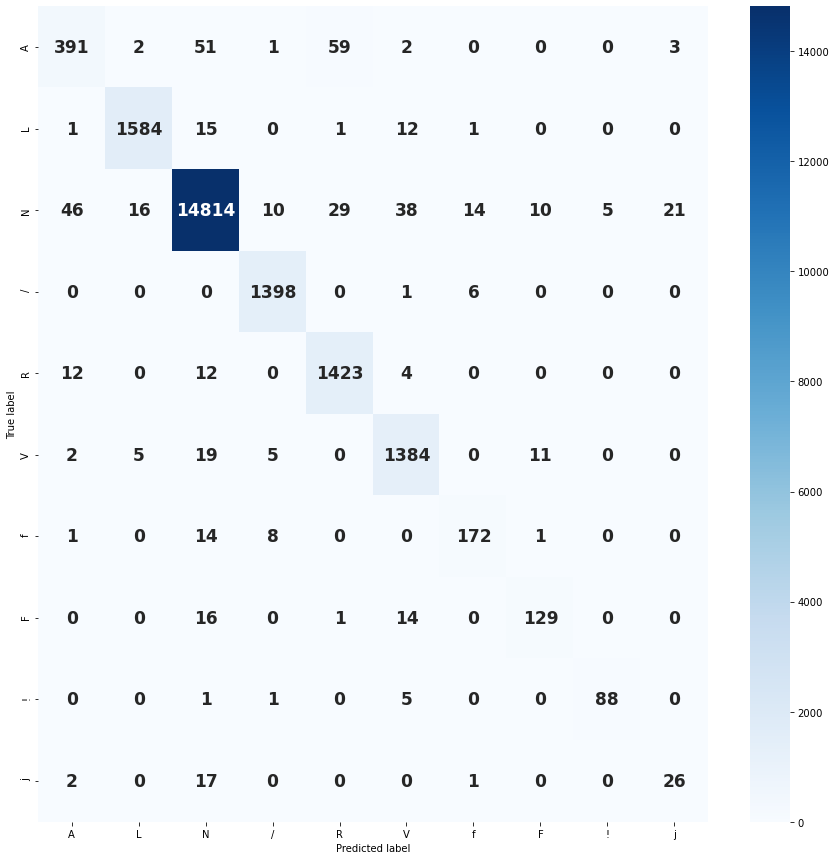



Metrics




precision    recall  f1-score  Accuracy
A     0.859341  0.768173  0.811203  0.991691
L     0.985688  0.981413  0.983545  0.997580
N     0.990307  0.987403  0.988853  0.984752
/     0.982431  0.995018  0.988685  0.998539
R     0.940516  0.980703  0.960189  0.994613
V     0.947945  0.970547  0.959113  0.994613
f     0.886598  0.877551  0.882051  0.997900
F     0.854305  0.806250  0.829582  0.997580
!     0.946237  0.926316  0.936170  0.999452
j     0.520000  0.565217  0.541667  0.997991
all   0.977357  0.977357  0.977357  0.977357

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [51]:
p = 50
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

In [16]:
TRAIN = {}
VAL = {}
TEST = {}
CONFIG = {}

for i in [55,60,65,70,75,80,85,90,95,100]:
    
    TRAIN[i],VAL[i],TEST[i],CONFIG[i] = data_processor(i,records,device,device_type,ecg_labels,beat_classes,beat_transform,beat_inv_transform)


------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 55 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-14-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.4680097103118896
+-> Min Training Loss : 2.368748664855957
+-> Min Training Loss : 2.3209125995635986
+-> Min Training Loss : 2.318610668182373
+-> Min Training Loss : 2.2825868129730225
+-> Min Training Loss : 2.2498652935028076
+-> Min Training Loss : 2.2183704376220703
+-> Min Training Loss : 2.016777515411377
+-> Min Training Loss : 1.960326910018921
+-> Min Training Loss : 1.9490290880203247
+-> Min Training Loss : 1.942675232887268
+-> Min Training Loss : 1.8303571939468384
+-> Min Training Loss : 1.7852942943572998
+-> Min Training Loss : 1.7028491497039795
+-> Min Training Loss : 1.640419363975525
+-> Min Training Loss : 1.618542194366455
+-> Min Training Loss : 1.615368366241455
+-> Min Training Loss : 1.6057960987091064
+-> Min Training Loss : 1.5389927625656128
+-> Min Training Loss : 1.5356366634368896
+-> Min Training Loss : 1.442548155784607
+-> Min Training Loss : 1.437537431716919
+-> Min Training Loss : 1.3447630405426025
+-> Min Training Loss

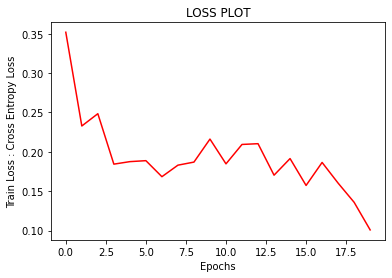

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


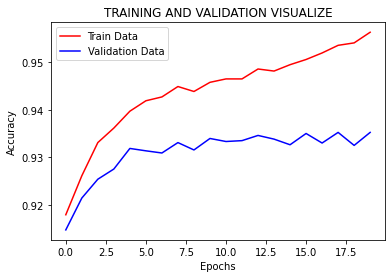

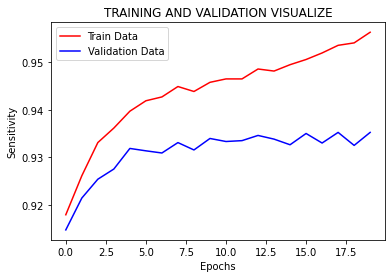

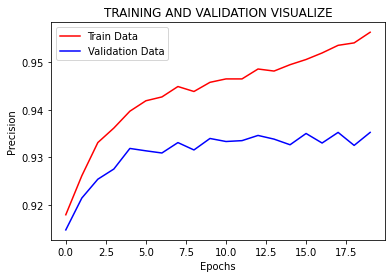

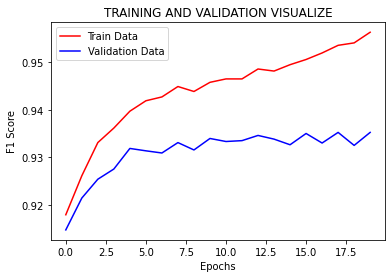

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




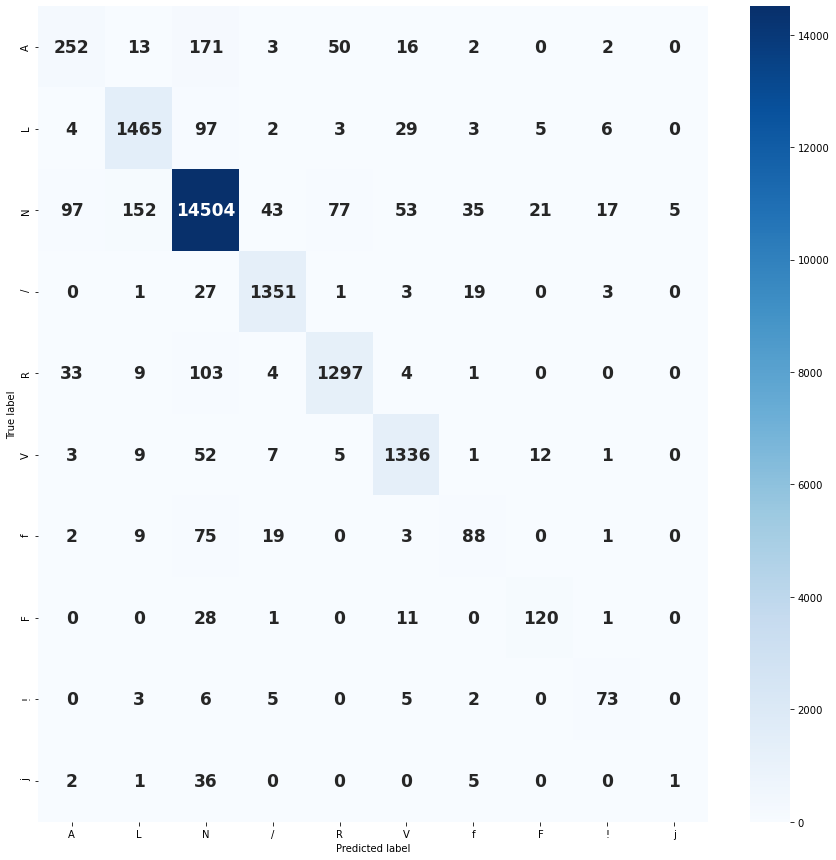



Metrics




precision    recall  f1-score  Accuracy
A     0.641221  0.495088  0.558758  0.981831
L     0.881468  0.907683  0.894383  0.984205
N     0.960593  0.966676  0.963625  0.950014
/     0.941463  0.961566  0.951408  0.993700
R     0.905094  0.893866  0.899445  0.986762
V     0.915068  0.936886  0.925849  0.990231
f     0.564103  0.446701  0.498584  0.991920
F     0.759494  0.745342  0.752351  0.996394
!     0.701923  0.776596  0.737374  0.997626
j     0.166667  0.022222  0.039216  0.997763
all   0.935223  0.935223  0.935223  0.935223

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




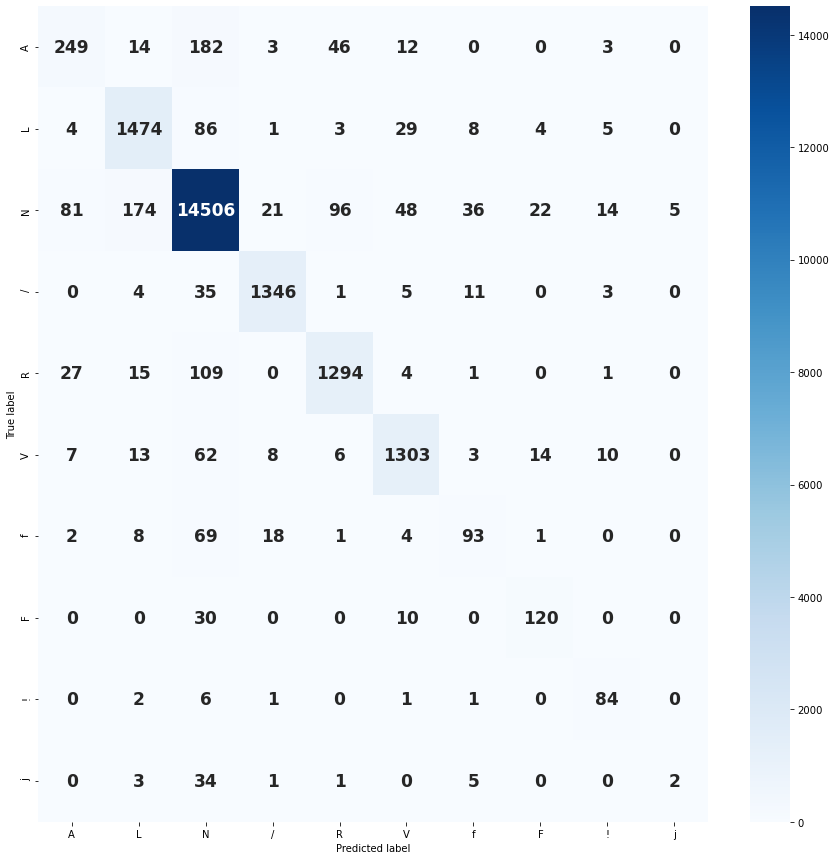



Metrics




precision    recall  f1-score  Accuracy
A     0.672973  0.489194  0.566553  0.982607
L     0.863503  0.913259  0.887684  0.982972
N     0.959455  0.966873  0.963150  0.949327
/     0.962116  0.958007  0.960057  0.994887
R     0.893646  0.891799  0.892722  0.985802
V     0.920198  0.913745  0.916960  0.989226
f     0.588608  0.474490  0.525424  0.992331
F     0.745342  0.750000  0.747664  0.996302
!     0.700000  0.884211  0.781395  0.997854
j     0.285714  0.043478  0.075472  0.997763
all   0.934535  0.934535  0.934535  0.934535

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [19]:
p = 55
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 60 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-14-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.228959560394287
+-> Min Training Loss : 2.0846376419067383
+-> Min Training Loss : 2.0288610458374023
+-> Min Training Loss : 1.9652774333953857
+-> Min Training Loss : 1.9051588773727417
+-> Min Training Loss : 1.8350286483764648
+-> Min Training Loss : 1.635825276374817
+-> Min Training Loss : 1.6238213777542114
+-> Min Training Loss : 1.5131651163101196
+-> Min Training Loss : 1.4001116752624512
+-> Min Training Loss : 1.3530343770980835
+-> Min Training Loss : 1.3229037523269653
+-> Min Training Loss : 1.2493175268173218
+-> Min Training Loss : 1.2303463220596313
+-> Min Training Loss : 1.0316623449325562
+-> Min Training Loss : 0.9752015471458435
+-> Min Training Loss : 0.8820822238922119
+-> Min Training Loss : 0.8312737345695496
+-> Min Training Loss : 0.8274616599082947
+-> Min Training Loss : 0.7638155817985535
+-> Min Training Loss : 0.6893422603607178
+-> Min Training Loss : 0.6768688559532166
+-> Min Training Loss : 0.6442261934280396
+-> Min Train

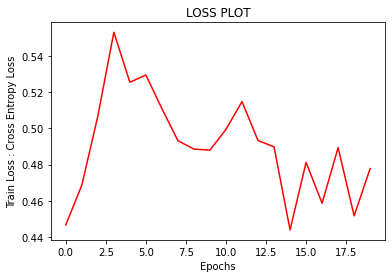

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


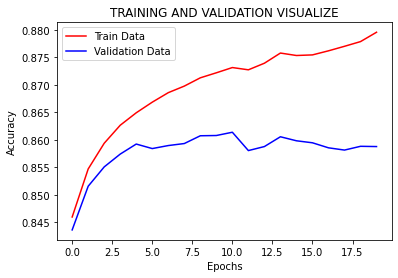

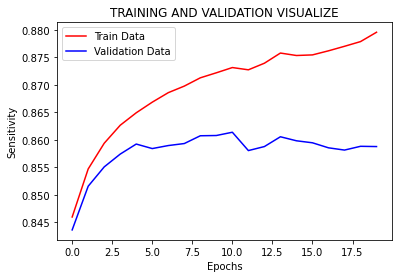

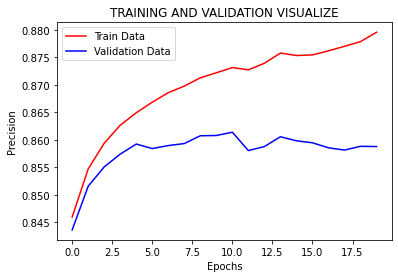

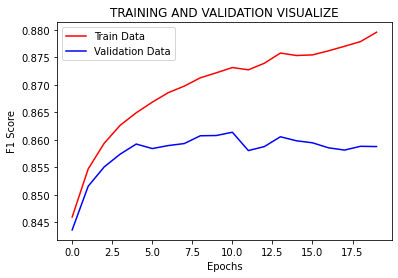

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




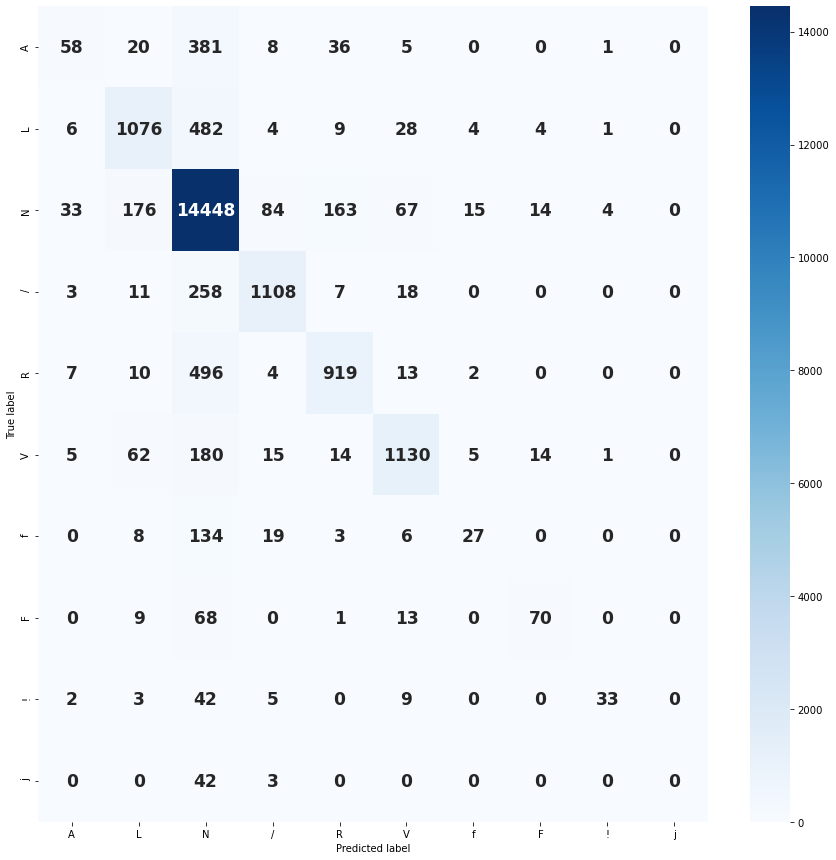



Metrics




precision    recall  f1-score  Accuracy
A     0.508772  0.113949  0.186196  0.976856
L     0.782545  0.666667  0.719973  0.961791
N     0.873994  0.962943  0.916315  0.879531
/     0.886400  0.788612  0.834652  0.979960
R     0.797743  0.633356  0.706108  0.965078
V     0.876649  0.792426  0.832413  0.979229
f     0.509434  0.137056  0.216000  0.991053
F     0.686275  0.434783  0.532319  0.994385
!     0.825000  0.351064  0.492537  0.996896
j     0.000000  0.000000  0.000000  0.997946
all   0.861362  0.861362  0.861362  0.861362

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




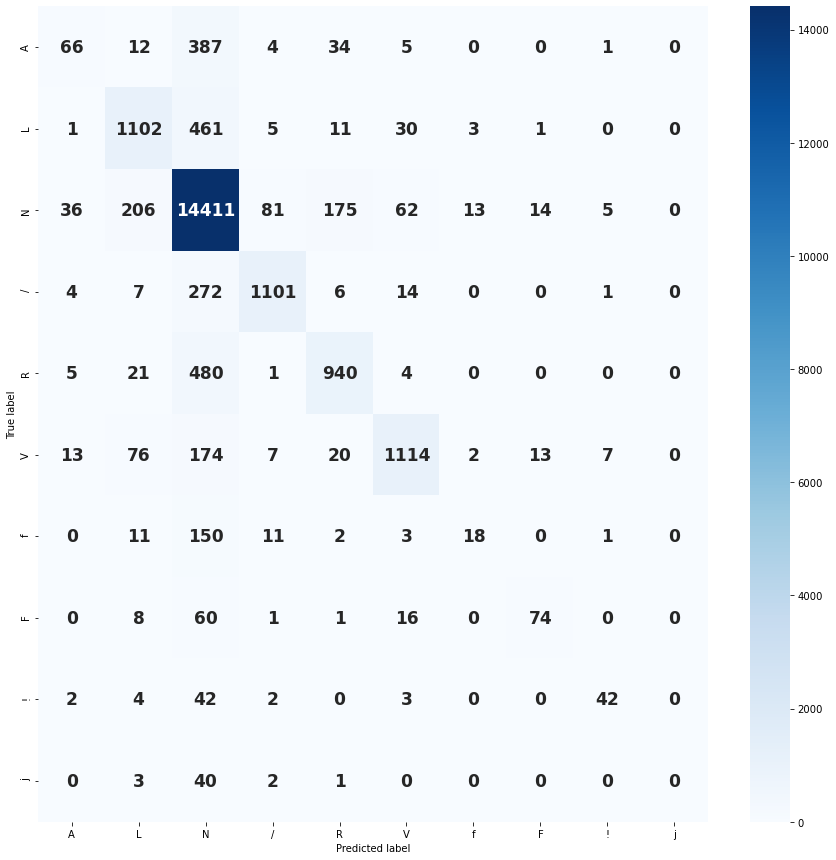



Metrics




precision    recall  f1-score  Accuracy
A     0.519685  0.129666  0.207547  0.976992
L     0.760000  0.682776  0.719321  0.960740
N     0.874613  0.960541  0.915565  0.878658
/     0.906173  0.783630  0.840458  0.980918
R     0.789916  0.647829  0.711852  0.965259
V     0.890488  0.781206  0.832275  0.979502
f     0.500000  0.091837  0.155172  0.991052
F     0.725490  0.462500  0.564885  0.994796
!     0.736842  0.442105  0.552632  0.996896
j     0.000000  0.000000  0.000000  0.997900
all   0.861356  0.861356  0.861356  0.861356

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [20]:
p = 60
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 65 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-14-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.224914312362671
+-> Min Training Loss : 2.1852307319641113
+-> Min Training Loss : 1.8986921310424805
+-> Min Training Loss : 1.866819143295288
+-> Min Training Loss : 1.7642004489898682
+-> Min Training Loss : 1.6943856477737427
+-> Min Training Loss : 1.6150789260864258
+-> Min Training Loss : 1.5432065725326538
+-> Min Training Loss : 1.397125005722046
+-> Min Training Loss : 1.3424650430679321
+-> Min Training Loss : 0.9655326008796692
+-> Min Training Loss : 0.9015489816665649
+-> Min Training Loss : 0.8516678810119629
+-> Min Training Loss : 0.8090898990631104
+-> Min Training Loss : 0.7355286478996277
+-> Min Training Loss : 0.7234939932823181
+-> Min Training Loss : 0.6920248866081238
+-> Min Training Loss : 0.6265055537223816
+-> Min Training Loss : 0.5456121563911438
+-> Min Training Loss : 0.5021511316299438
+-> Min Training Loss : 0.47340601682662964
+-> Min Training Loss : 0.4717268645763397
+-> Min Training Loss : 0.46001172065734863
+-> Min Trai

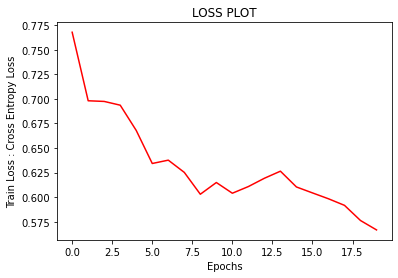

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


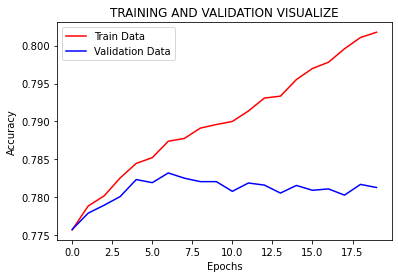

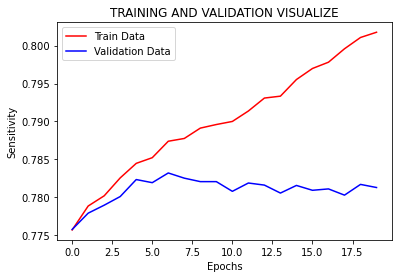

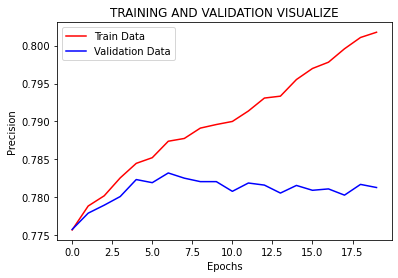

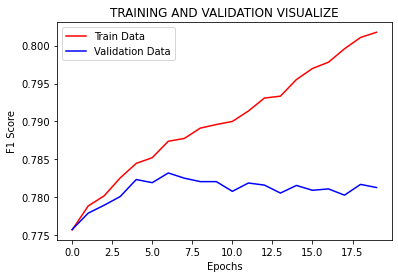

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




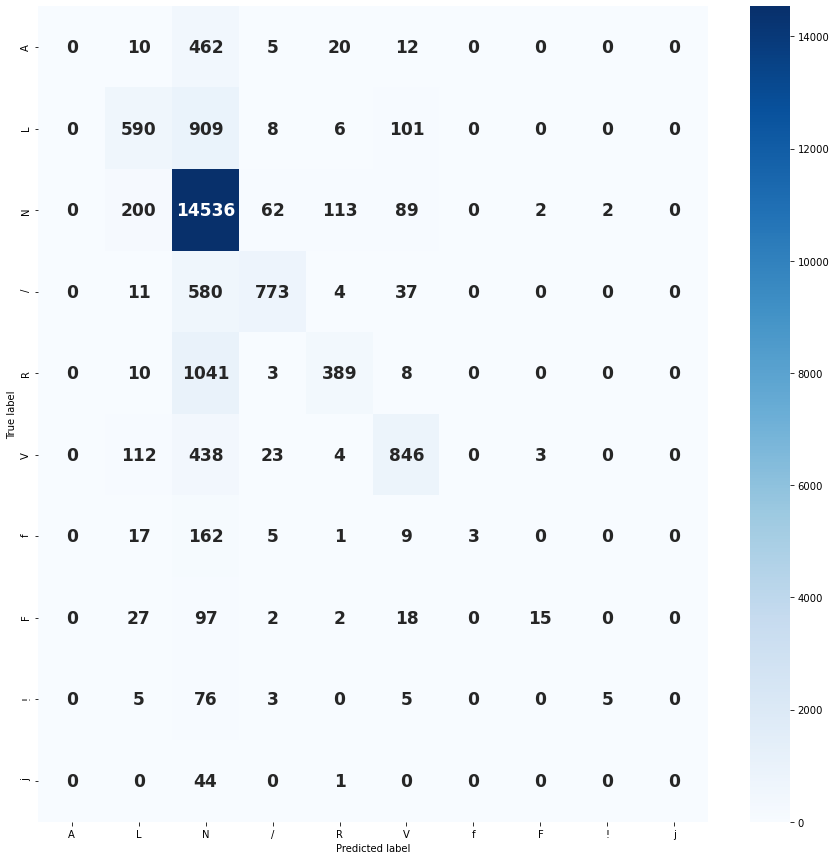



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976764
L     0.600815  0.365551  0.454545  0.935360
N     0.792368  0.968808  0.871750  0.804757
/     0.874434  0.550178  0.675404  0.966082
R     0.720370  0.268091  0.390758  0.944627
V     0.752000  0.593268  0.663269  0.960787
f     1.000000  0.015228  0.030000  0.991144
F     0.750000  0.093168  0.165746  0.993107
!     0.714286  0.053191  0.099010  0.995846
j     0.000000  0.000000  0.000000  0.997946
all   0.783210  0.783210  0.783210  0.783210

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




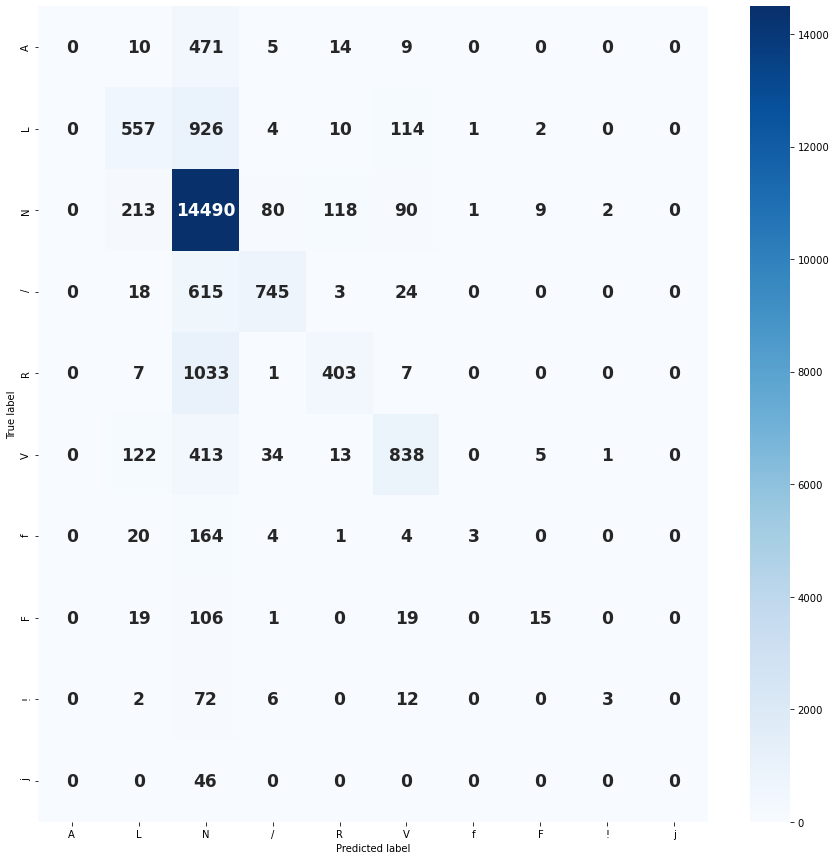



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976763
L     0.575413  0.345105  0.431448  0.932983
N     0.790249  0.965807  0.869252  0.801004
/     0.846591  0.530249  0.652079  0.963707
R     0.717082  0.277739  0.400397  0.944898
V     0.750224  0.587658  0.659064  0.960420
f     0.600000  0.015306  0.029851  0.991098
F     0.483871  0.093750  0.157068  0.992650
!     0.500000  0.031579  0.059406  0.995663
j     0.000000  0.000000  0.000000  0.997900
all   0.778544  0.778544  0.778544  0.778544

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [21]:
p = 65
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 70 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-14-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.420323133468628
+-> Min Training Loss : 2.3052124977111816
+-> Min Training Loss : 2.302412986755371
+-> Min Training Loss : 2.2838029861450195
+-> Min Training Loss : 2.2090823650360107
+-> Min Training Loss : 2.1994717121124268
+-> Min Training Loss : 2.1449155807495117
+-> Min Training Loss : 2.078620433807373
+-> Min Training Loss : 2.005924940109253
+-> Min Training Loss : 1.9967702627182007
+-> Min Training Loss : 1.982767939567566
+-> Min Training Loss : 1.9381276369094849
+-> Min Training Loss : 1.8639543056488037
+-> Min Training Loss : 1.8028513193130493
+-> Min Training Loss : 1.711895227432251
+-> Min Training Loss : 1.6387213468551636
+-> Min Training Loss : 1.6041406393051147
+-> Min Training Loss : 1.591214895248413
+-> Min Training Loss : 1.4974030256271362
+-> Min Training Loss : 1.2653594017028809
+-> Min Training Loss : 1.2536799907684326
+-> Min Training Loss : 1.2265658378601074
+-> Min Training Loss : 1.133732557296753
+-> Min Training Lo

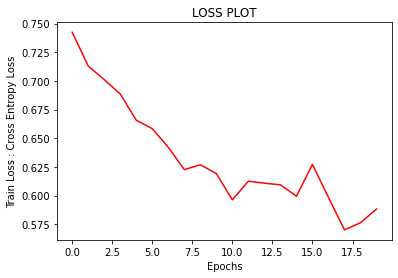

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


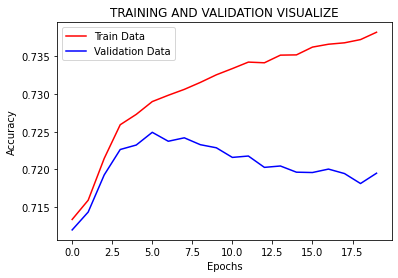

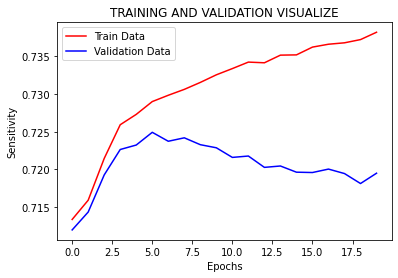

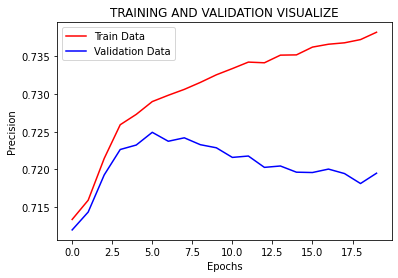

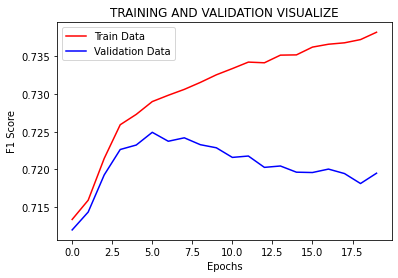

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




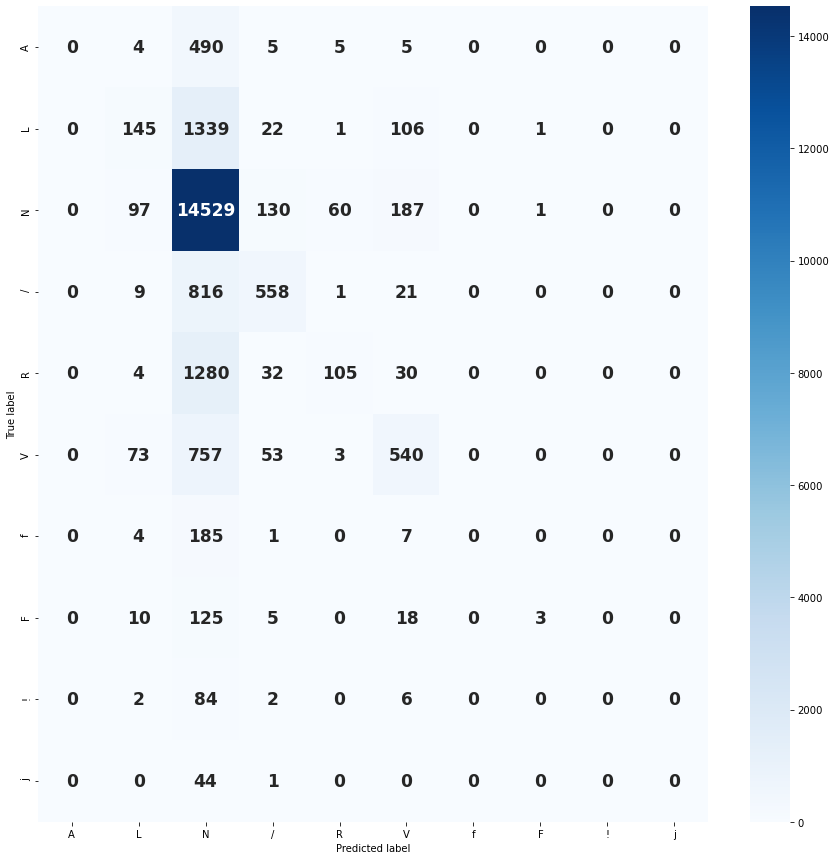



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976764
L     0.416667  0.089839  0.147808  0.923674
N     0.739427  0.968342  0.838542  0.744591
/     0.689740  0.397153  0.504065  0.949877
R     0.600000  0.072364  0.129151  0.935360
V     0.586957  0.378682  0.460358  0.942208
f     0.000000  0.000000  0.000000  0.991007
F     0.600000  0.018634  0.036145  0.992696
!     0.000000  0.000000  0.000000  0.995709
j     0.000000  0.000000  0.000000  0.997946
all   0.724916  0.724916  0.724916  0.724916

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




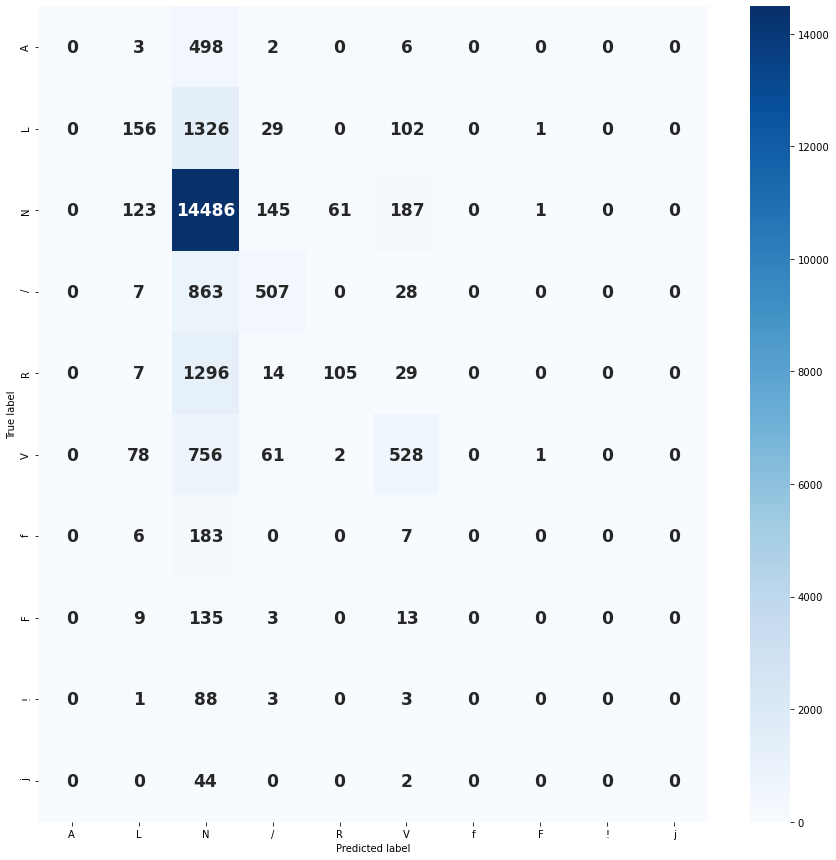



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976763
L     0.400000  0.096654  0.155689  0.922757
N     0.736264  0.965540  0.835458  0.739512
/     0.663613  0.360854  0.467497  0.947272
R     0.625000  0.072364  0.129710  0.935677
V     0.583425  0.370266  0.453024  0.941794
f     0.000000  0.000000  0.000000  0.991052
F     0.000000  0.000000  0.000000  0.992559
!     0.000000  0.000000  0.000000  0.995663
j     0.000000  0.000000  0.000000  0.997900
all   0.720475  0.720475  0.720475  0.720475

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [22]:
p = 70
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 75 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-14-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.2396068572998047
+-> Min Training Loss : 2.226445436477661
+-> Min Training Loss : 2.175168991088867
+-> Min Training Loss : 2.1217355728149414
+-> Min Training Loss : 2.0707273483276367
+-> Min Training Loss : 2.0628113746643066
+-> Min Training Loss : 2.0544214248657227
+-> Min Training Loss : 2.01836895942688
+-> Min Training Loss : 1.9837050437927246
+-> Min Training Loss : 1.8770616054534912
+-> Min Training Loss : 1.82359778881073
+-> Min Training Loss : 1.790105938911438
+-> Min Training Loss : 1.7414815425872803
+-> Min Training Loss : 1.6944701671600342
+-> Min Training Loss : 1.691426396369934
+-> Min Training Loss : 1.5946825742721558
+-> Min Training Loss : 1.5852949619293213
+-> Min Training Loss : 1.404615879058838
+-> Min Training Loss : 1.1197481155395508
+-> Min Training Loss : 1.0910447835922241
+-> Min Training Loss : 0.9599044919013977
+-> Min Training Loss : 0.9546200037002563
+-> Min Training Loss : 0.8620994687080383
+-> Min Training Los

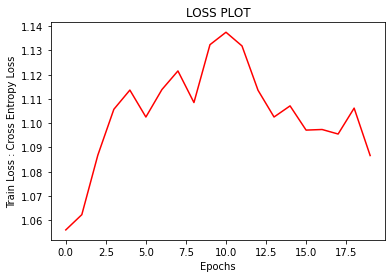

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


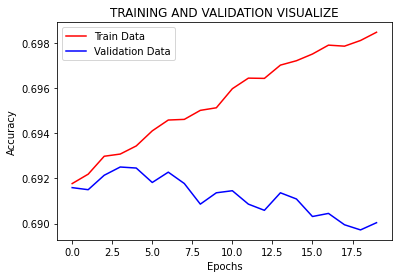

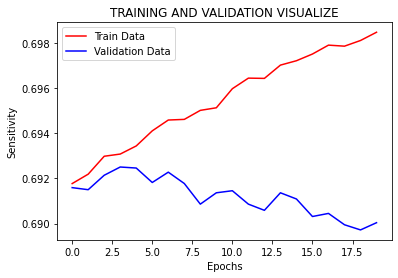

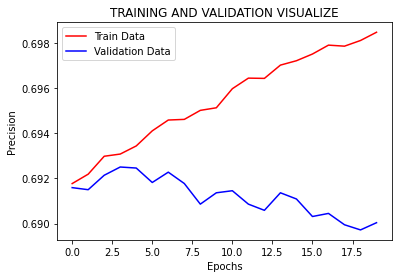

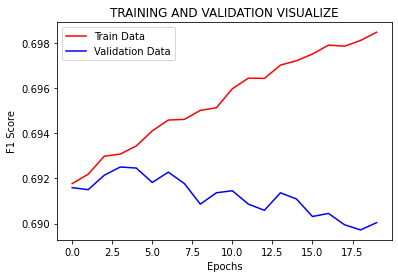

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




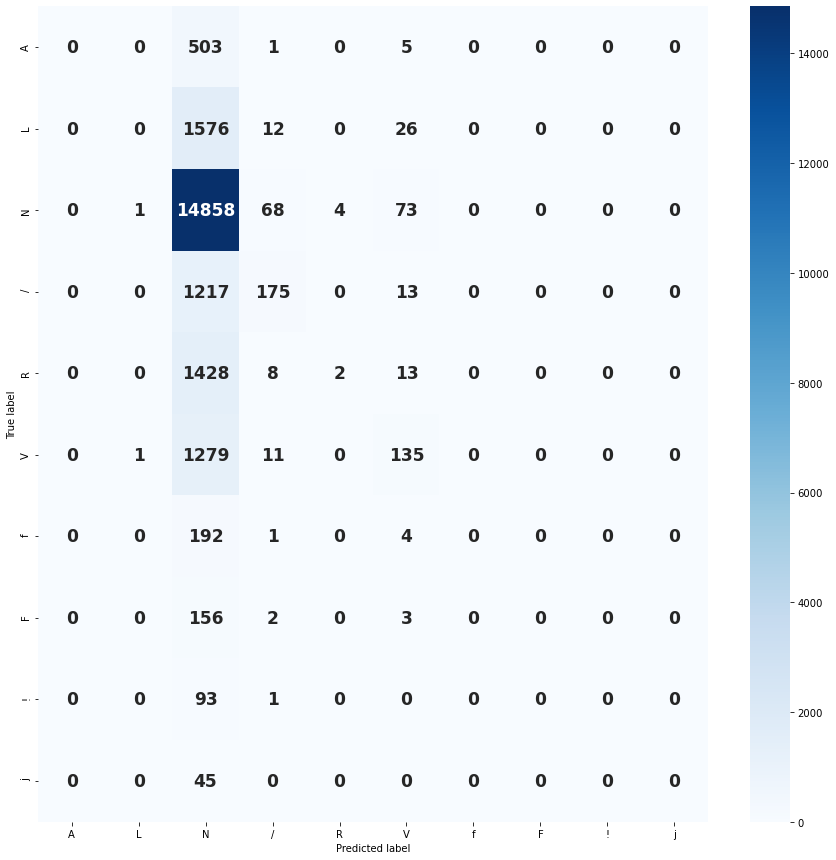



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976764
L     0.000000  0.000000  0.000000  0.926230
N     0.696023  0.990269  0.817474  0.697115
/     0.627240  0.124555  0.207838  0.939103
R     0.333333  0.001378  0.002745  0.933671
V     0.496324  0.094670  0.159011  0.934812
f     0.000000  0.000000  0.000000  0.991007
F     0.000000  0.000000  0.000000  0.992650
!     0.000000  0.000000  0.000000  0.995709
j     0.000000  0.000000  0.000000  0.997946
all   0.692504  0.692504  0.692504  0.692504

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




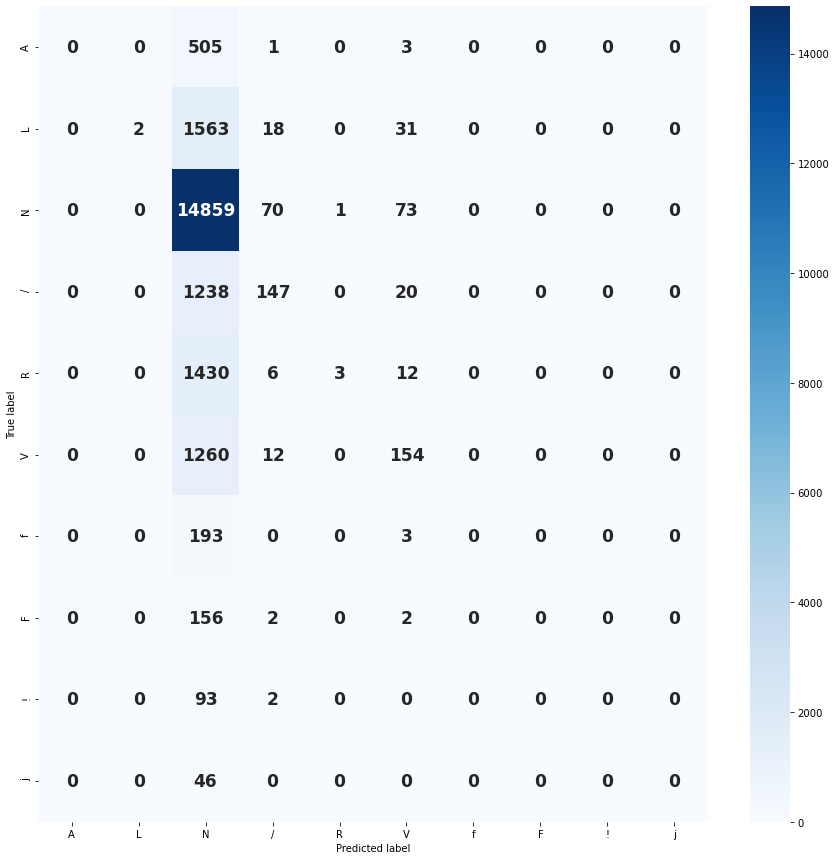



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976763
L     1.000000  0.001239  0.002475  0.926409
N     0.696200  0.990402  0.817642  0.697421
/     0.569767  0.104626  0.176789  0.937503
R     0.750000  0.002068  0.004124  0.933851
V     0.516779  0.107994  0.178654  0.935357
f     0.000000  0.000000  0.000000  0.991052
F     0.000000  0.000000  0.000000  0.992696
!     0.000000  0.000000  0.000000  0.995663
j     0.000000  0.000000  0.000000  0.997900
all   0.692308  0.692308  0.692308  0.692308

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [23]:
p = 75
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 80 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-14-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.496570348739624
+-> Min Training Loss : 2.477931261062622
+-> Min Training Loss : 2.4224188327789307
+-> Min Training Loss : 2.3618016242980957
+-> Min Training Loss : 2.304131269454956
+-> Min Training Loss : 2.282042980194092
+-> Min Training Loss : 2.1385579109191895
+-> Min Training Loss : 2.130547285079956
+-> Min Training Loss : 2.1145684719085693
+-> Min Training Loss : 2.0794262886047363
+-> Min Training Loss : 2.0086357593536377
+-> Min Training Loss : 1.917068362236023
+-> Min Training Loss : 1.8455445766448975
+-> Min Training Loss : 1.802656888961792
+-> Min Training Loss : 1.7855684757232666
+-> Min Training Loss : 1.7132351398468018
+-> Min Training Loss : 1.659083604812622
+-> Min Training Loss : 1.6581428050994873
+-> Min Training Loss : 1.5749764442443848
+-> Min Training Loss : 1.3052195310592651
+-> Min Training Loss : 1.2621991634368896
+-> Min Training Loss : 1.1169984340667725
+-> Min Training Loss : 1.0414149761199951
+-> Min Training Lo

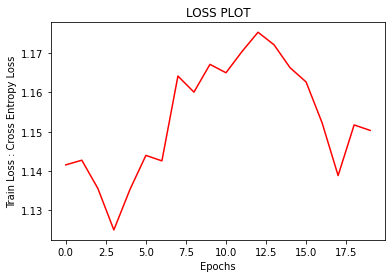

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


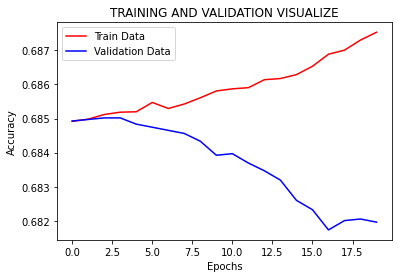

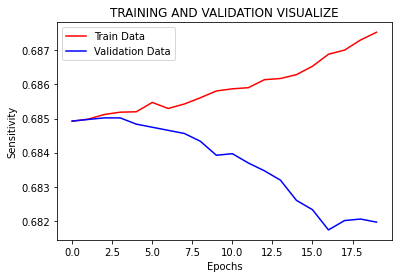

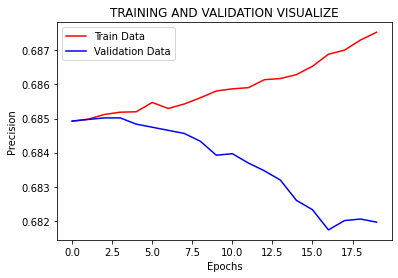

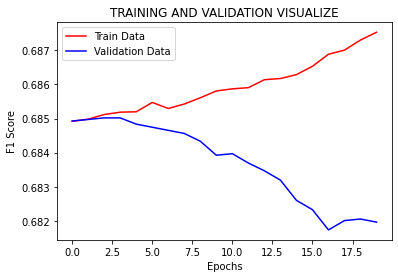

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




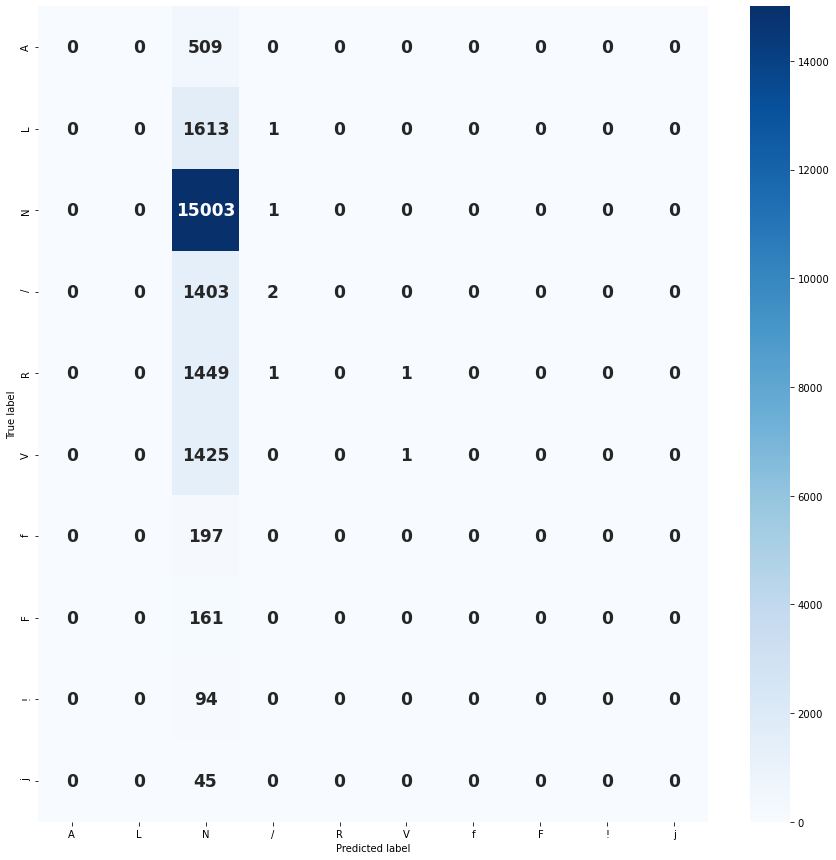



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976764
L     0.000000  0.000000  0.000000  0.926322
N     0.685100  0.999933  0.813105  0.685155
/     0.400000  0.001423  0.002837  0.935817
R     0.000000  0.000000  0.000000  0.933762
V     0.500000  0.000701  0.001401  0.934904
f     0.000000  0.000000  0.000000  0.991007
F     0.000000  0.000000  0.000000  0.992650
!     0.000000  0.000000  0.000000  0.995709
j     0.000000  0.000000  0.000000  0.997946
all   0.685018  0.685018  0.685018  0.685018

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




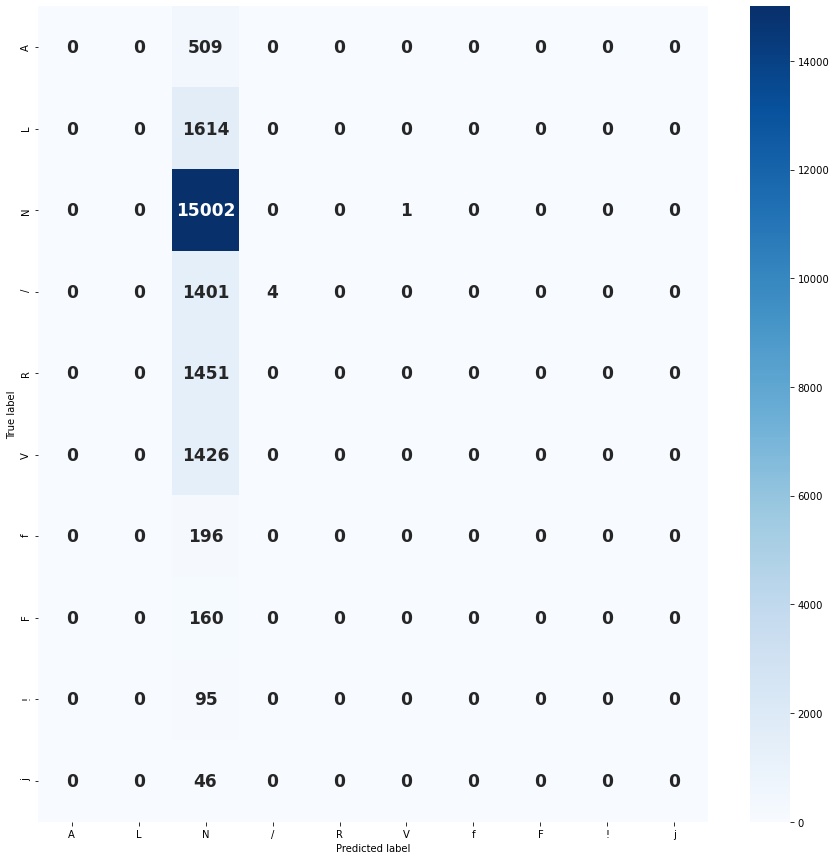



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976763
L     0.000000  0.000000  0.000000  0.926318
N     0.685023  0.999933  0.813050  0.685049
/     1.000000  0.002847  0.005678  0.936042
R     0.000000  0.000000  0.000000  0.933759
V     0.000000  0.000000  0.000000  0.934855
f     0.000000  0.000000  0.000000  0.991052
F     0.000000  0.000000  0.000000  0.992696
!     0.000000  0.000000  0.000000  0.995663
j     0.000000  0.000000  0.000000  0.997900
all   0.685049  0.685049  0.685049  0.685049

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [24]:
p = 80
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 85 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-14-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.33473801612854
+-> Min Training Loss : 2.294736385345459
+-> Min Training Loss : 2.226034164428711
+-> Min Training Loss : 2.191779851913452
+-> Min Training Loss : 2.1664209365844727
+-> Min Training Loss : 2.1261157989501953
+-> Min Training Loss : 2.1198670864105225
+-> Min Training Loss : 2.073652505874634
+-> Min Training Loss : 2.071519613265991
+-> Min Training Loss : 1.9234615564346313
+-> Min Training Loss : 1.8802769184112549
+-> Min Training Loss : 1.8600436449050903
+-> Min Training Loss : 1.8186366558074951
+-> Min Training Loss : 1.7725250720977783
+-> Min Training Loss : 1.7124418020248413
+-> Min Training Loss : 1.6695693731307983
+-> Min Training Loss : 1.5718671083450317
+-> Min Training Loss : 1.5614186525344849
+-> Min Training Loss : 1.1630295515060425
+-> Min Training Loss : 1.1621805429458618
+-> Min Training Loss : 1.0627878904342651
+-> Min Training Loss : 1.0295352935791016
+-> Min Training Loss : 0.9414942860603333
+-> Min Training L

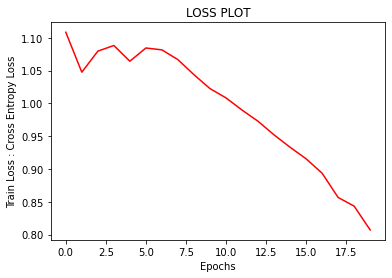

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


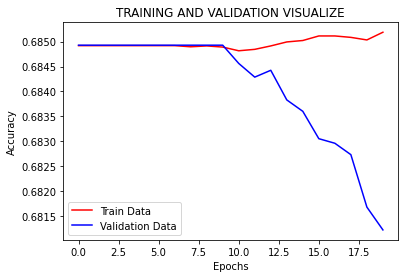

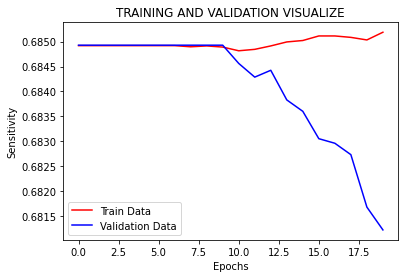

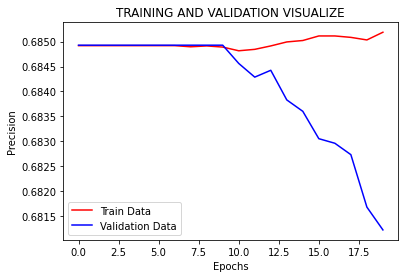

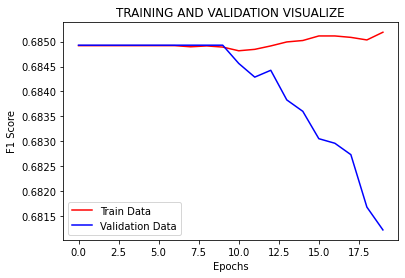

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




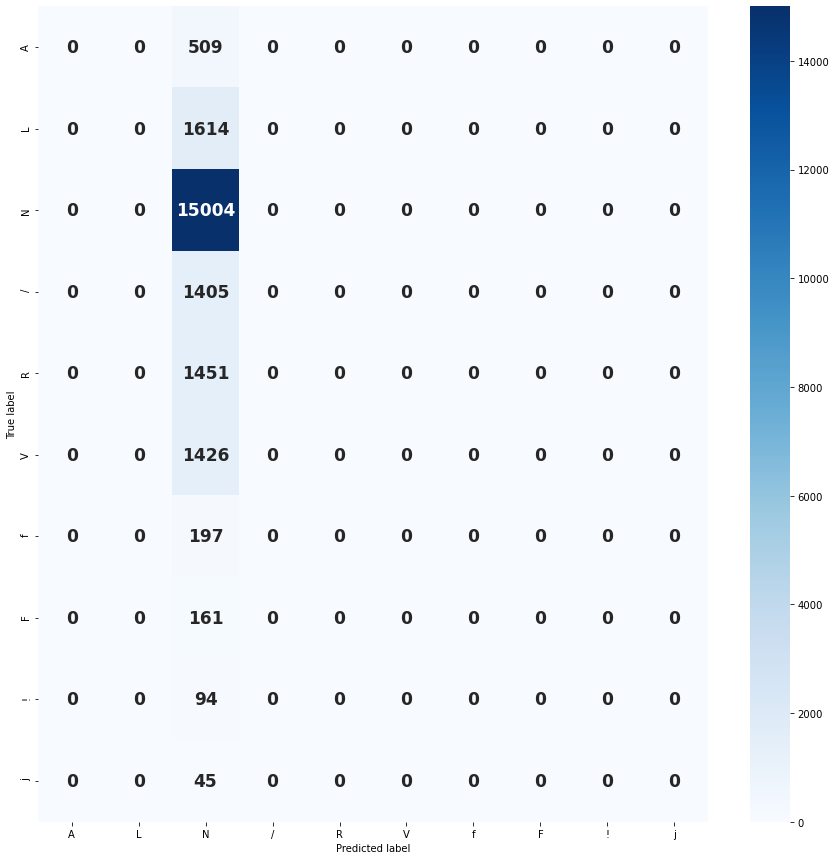



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976764
L     0.000000  0.000000  0.000000  0.926322
N     0.684927  1.000000  0.813005  0.684927
/     0.000000  0.000000  0.000000  0.935862
R     0.000000  0.000000  0.000000  0.933762
V     0.000000  0.000000  0.000000  0.934904
f     0.000000  0.000000  0.000000  0.991007
F     0.000000  0.000000  0.000000  0.992650
!     0.000000  0.000000  0.000000  0.995709
j     0.000000  0.000000  0.000000  0.997946
all   0.684927  0.684927  0.684927  0.684927

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




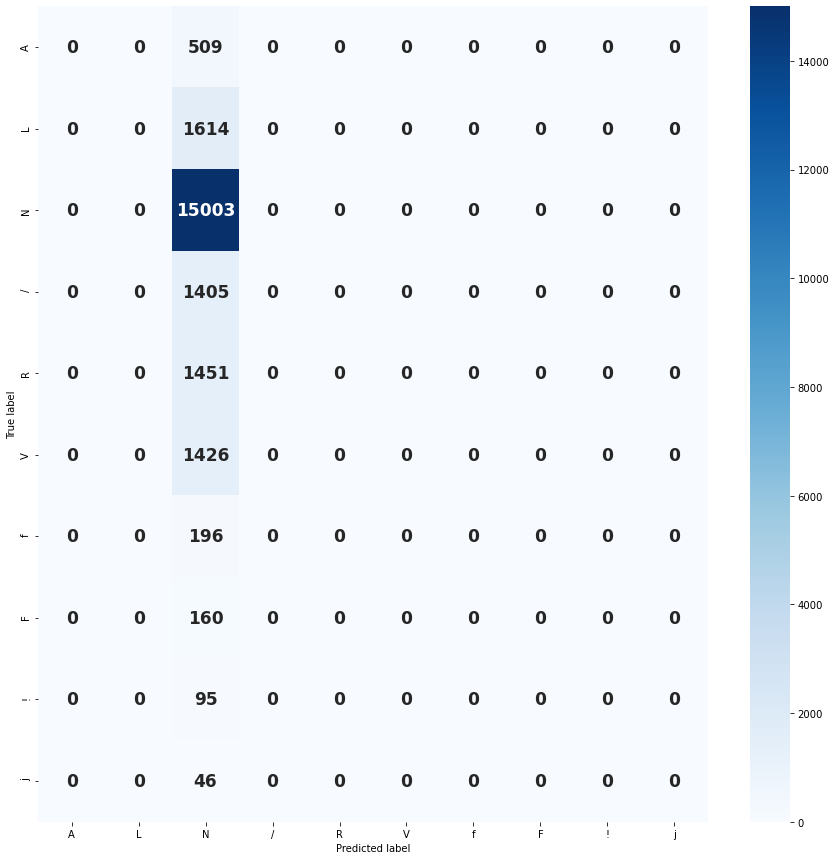



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976763
L     0.000000  0.000000  0.000000  0.926318
N     0.684912  1.000000  0.812994  0.684912
/     0.000000  0.000000  0.000000  0.935859
R     0.000000  0.000000  0.000000  0.933759
V     0.000000  0.000000  0.000000  0.934901
f     0.000000  0.000000  0.000000  0.991052
F     0.000000  0.000000  0.000000  0.992696
!     0.000000  0.000000  0.000000  0.995663
j     0.000000  0.000000  0.000000  0.997900
all   0.684912  0.684912  0.684912  0.684912

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [25]:
p = 85
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 90 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-14-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.4285571575164795
+-> Min Training Loss : 2.300466775894165
+-> Min Training Loss : 2.2533650398254395
+-> Min Training Loss : 2.222130060195923
+-> Min Training Loss : 2.0930120944976807
+-> Min Training Loss : 1.9916269779205322
+-> Min Training Loss : 1.966383695602417
+-> Min Training Loss : 1.9076586961746216
+-> Min Training Loss : 1.829964518547058
+-> Min Training Loss : 1.8014572858810425
+-> Min Training Loss : 1.608177661895752
+-> Min Training Loss : 1.6033141613006592
+-> Min Training Loss : 1.5033878087997437
+-> Min Training Loss : 1.242760419845581
+-> Min Training Loss : 1.1229729652404785
+-> Min Training Loss : 1.106386423110962
+-> Min Training Loss : 1.0707550048828125
+-> Min Training Loss : 1.0174444913864136
+-> Min Training Loss : 0.8936183452606201
+-> Min Training Loss : 0.8180899620056152
+-> Min Training Loss : 0.797851026058197
+-> Min Training Loss : 0.7966854572296143
+-> Min Training Loss : 0.7813586592674255
+-> Min Training Lo

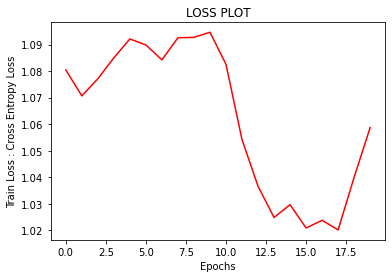

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


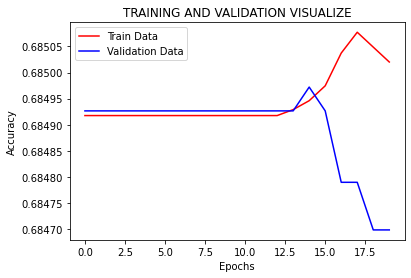

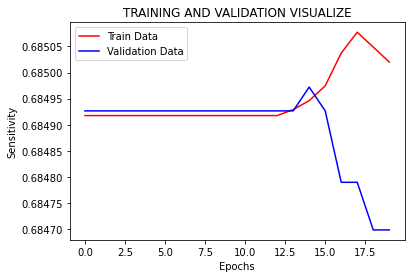

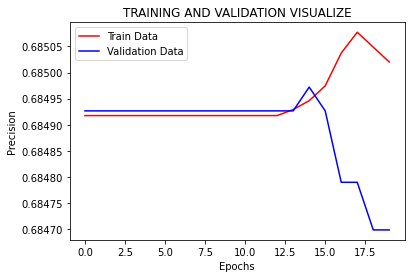

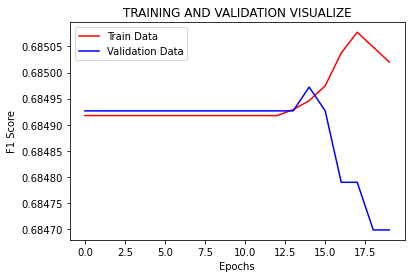

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




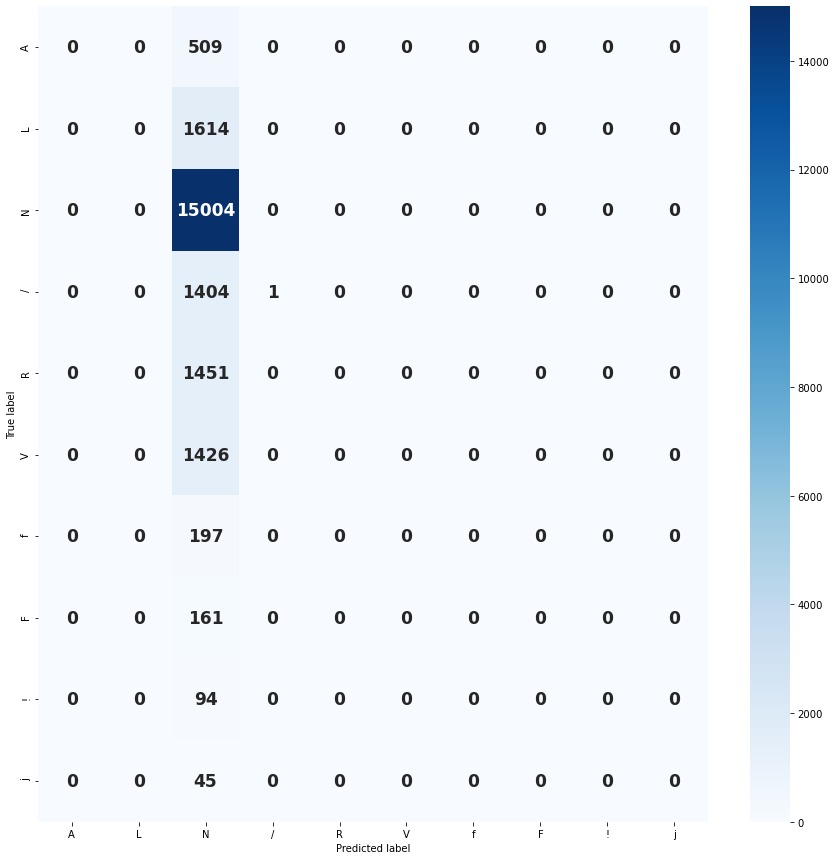



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976764
L     0.000000  0.000000  0.000000  0.926322
N     0.684958  1.000000  0.813027  0.684972
/     1.000000  0.000712  0.001422  0.935908
R     0.000000  0.000000  0.000000  0.933762
V     0.000000  0.000000  0.000000  0.934904
f     0.000000  0.000000  0.000000  0.991007
F     0.000000  0.000000  0.000000  0.992650
!     0.000000  0.000000  0.000000  0.995709
j     0.000000  0.000000  0.000000  0.997946
all   0.684972  0.684972  0.684972  0.684972

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




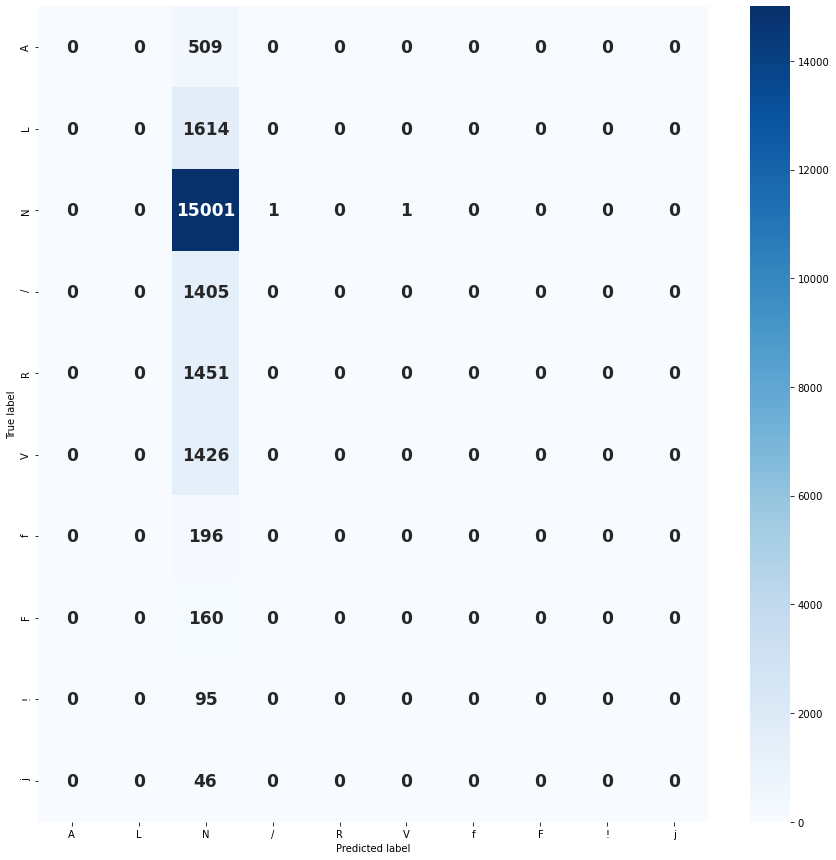



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976763
L     0.000000  0.000000  0.000000  0.926318
N     0.684883  0.999867  0.812930  0.684821
/     0.000000  0.000000  0.000000  0.935814
R     0.000000  0.000000  0.000000  0.933759
V     0.000000  0.000000  0.000000  0.934855
f     0.000000  0.000000  0.000000  0.991052
F     0.000000  0.000000  0.000000  0.992696
!     0.000000  0.000000  0.000000  0.995663
j     0.000000  0.000000  0.000000  0.997900
all   0.684821  0.684821  0.684821  0.684821

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [26]:
p = 90
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 95 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-14-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.4855434894561768
+-> Min Training Loss : 2.4553112983703613
+-> Min Training Loss : 2.418301582336426
+-> Min Training Loss : 2.3445162773132324
+-> Min Training Loss : 2.289410352706909
+-> Min Training Loss : 2.207343578338623
+-> Min Training Loss : 2.127824544906616
+-> Min Training Loss : 2.1063051223754883
+-> Min Training Loss : 1.9984560012817383
+-> Min Training Loss : 1.988092064857483
+-> Min Training Loss : 1.9672118425369263
+-> Min Training Loss : 1.9374401569366455
+-> Min Training Loss : 1.854781985282898
+-> Min Training Loss : 1.789689064025879
+-> Min Training Loss : 1.6925357580184937
+-> Min Training Loss : 1.6382137537002563
+-> Min Training Loss : 1.5986661911010742
+-> Min Training Loss : 1.3454777002334595
+-> Min Training Loss : 1.253232717514038
+-> Min Training Loss : 1.2356833219528198
+-> Min Training Loss : 1.23418128490448
+-> Min Training Loss : 1.2314306497573853
+-> Min Training Loss : 1.1298186779022217
+-> Min Training Loss

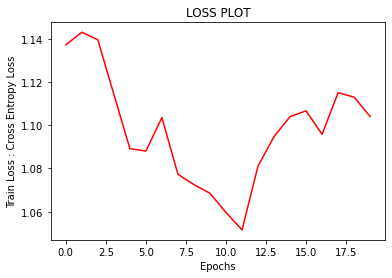

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


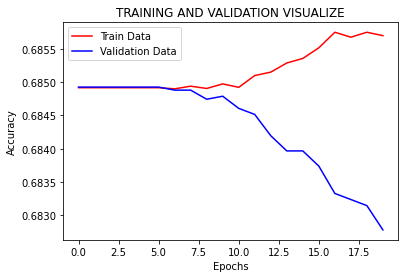

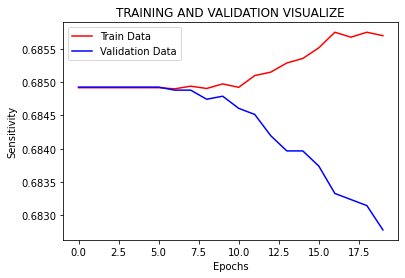

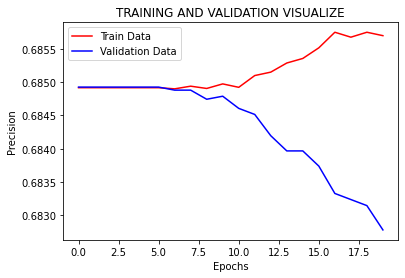

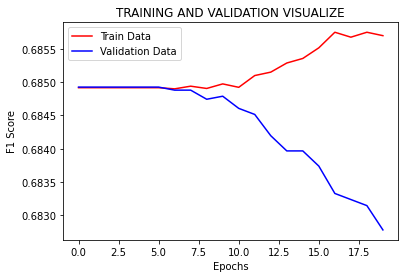

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




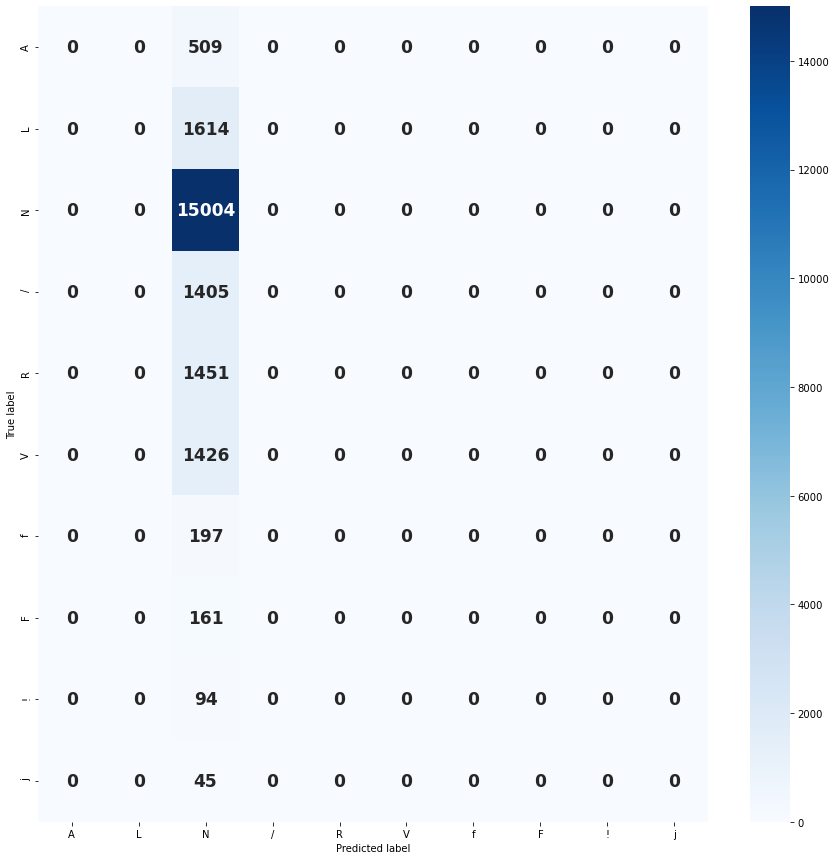



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976764
L     0.000000  0.000000  0.000000  0.926322
N     0.684927  1.000000  0.813005  0.684927
/     0.000000  0.000000  0.000000  0.935862
R     0.000000  0.000000  0.000000  0.933762
V     0.000000  0.000000  0.000000  0.934904
f     0.000000  0.000000  0.000000  0.991007
F     0.000000  0.000000  0.000000  0.992650
!     0.000000  0.000000  0.000000  0.995709
j     0.000000  0.000000  0.000000  0.997946
all   0.684927  0.684927  0.684927  0.684927

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




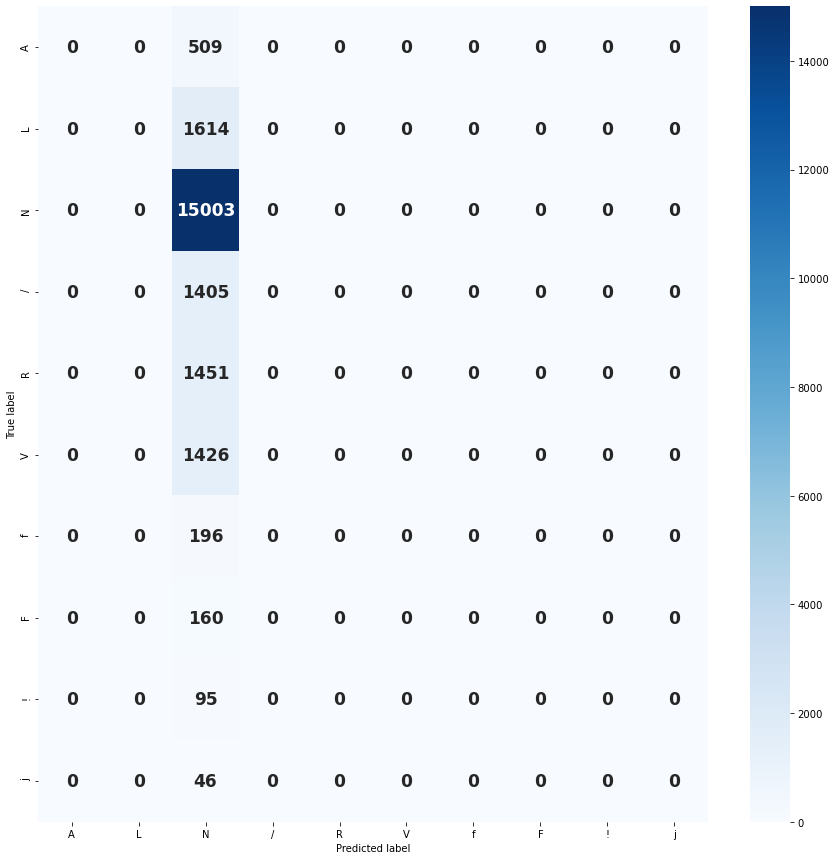



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976763
L     0.000000  0.000000  0.000000  0.926318
N     0.684912  1.000000  0.812994  0.684912
/     0.000000  0.000000  0.000000  0.935859
R     0.000000  0.000000  0.000000  0.933759
V     0.000000  0.000000  0.000000  0.934901
f     0.000000  0.000000  0.000000  0.991052
F     0.000000  0.000000  0.000000  0.992696
!     0.000000  0.000000  0.000000  0.995663
j     0.000000  0.000000  0.000000  0.997900
all   0.684912  0.684912  0.684912  0.684912

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [27]:
p = 95
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> Noise Level : 100 dB
--> You are using a  gpu
--> The epochs specified for training :  20
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


<ipython-input-14-16908da88d1e>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):


+-> Min Training Loss : 2.305208444595337
+-> Min Training Loss : 2.1599841117858887
+-> Min Training Loss : 2.0869903564453125
+-> Min Training Loss : 2.007227897644043
+-> Min Training Loss : 1.908076286315918
+-> Min Training Loss : 1.8441356420516968
+-> Min Training Loss : 1.8411144018173218
+-> Min Training Loss : 1.770896315574646
+-> Min Training Loss : 1.743816614151001
+-> Min Training Loss : 1.717418909072876
+-> Min Training Loss : 1.6650198698043823
+-> Min Training Loss : 1.663268804550171
+-> Min Training Loss : 1.5460503101348877
+-> Min Training Loss : 1.5111080408096313
+-> Min Training Loss : 1.4487121105194092
+-> Min Training Loss : 1.444573998451233
+-> Min Training Loss : 1.3197442293167114
+-> Min Training Loss : 1.0539618730545044
+-> Min Training Loss : 1.034264326095581
+-> Min Training Loss : 1.0063276290893555
+-> Min Training Loss : 0.9959619641304016
+-> Min Training Loss : 0.9421266913414001
+-> Min Training Loss : 0.845500111579895
+-> Min Training Loss

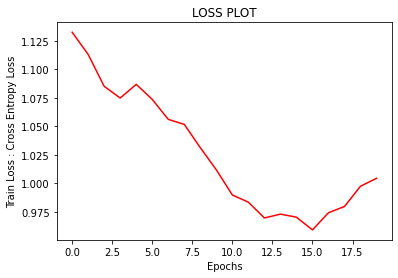

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


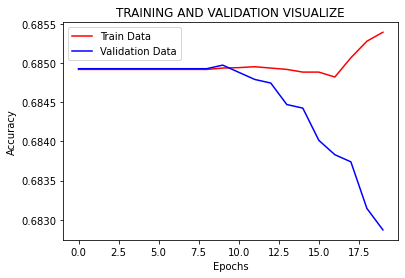

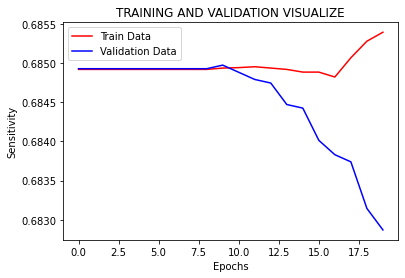

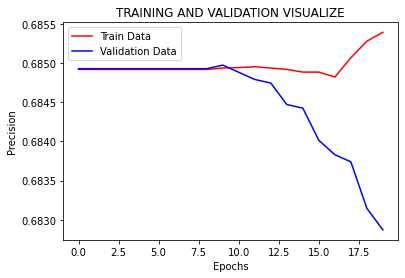

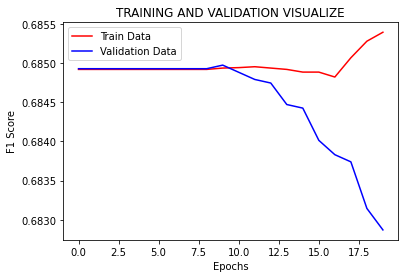

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




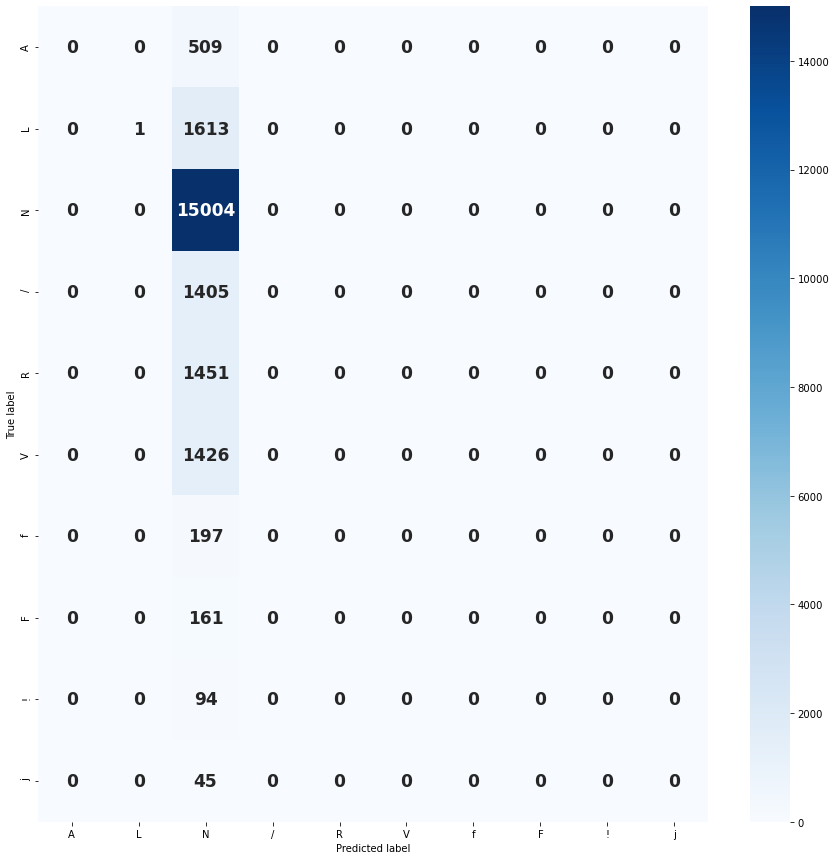



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976764
L     1.000000  0.000620  0.001238  0.926367
N     0.684958  1.000000  0.813027  0.684972
/     0.000000  0.000000  0.000000  0.935862
R     0.000000  0.000000  0.000000  0.933762
V     0.000000  0.000000  0.000000  0.934904
f     0.000000  0.000000  0.000000  0.991007
F     0.000000  0.000000  0.000000  0.992650
!     0.000000  0.000000  0.000000  0.995709
j     0.000000  0.000000  0.000000  0.997946
all   0.684972  0.684972  0.684972  0.684972

------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------


C:\Users\dsriaditya999\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix




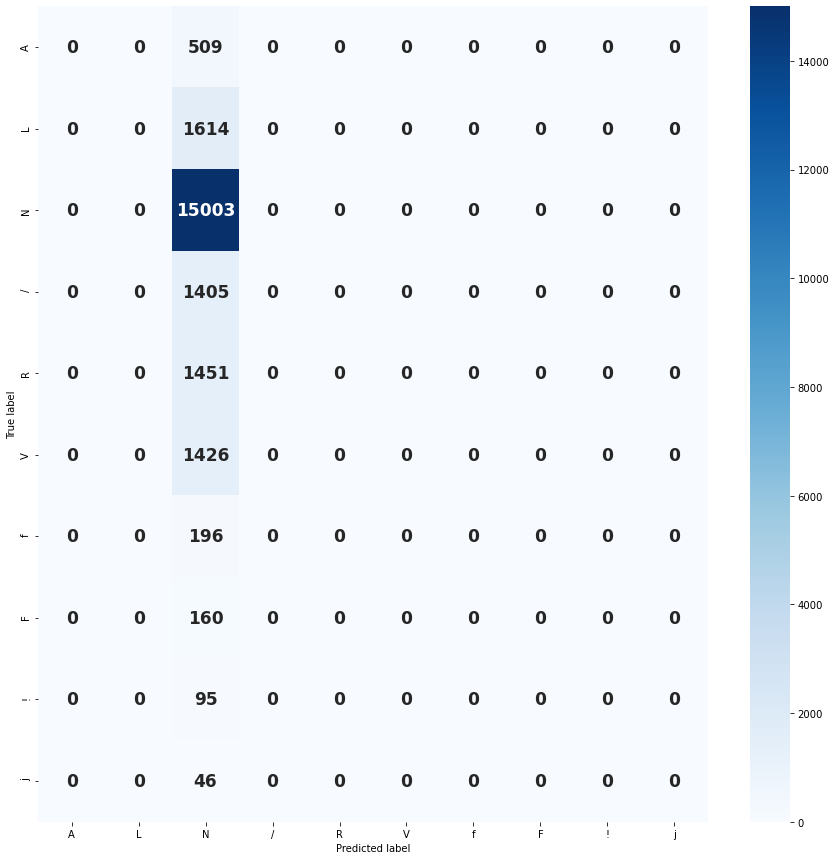



Metrics




precision    recall  f1-score  Accuracy
A     0.000000  0.000000  0.000000  0.976763
L     0.000000  0.000000  0.000000  0.926318
N     0.684912  1.000000  0.812994  0.684912
/     0.000000  0.000000  0.000000  0.935859
R     0.000000  0.000000  0.000000  0.933759
V     0.000000  0.000000  0.000000  0.934901
f     0.000000  0.000000  0.000000  0.991052
F     0.000000  0.000000  0.000000  0.992696
!     0.000000  0.000000  0.000000  0.995663
j     0.000000  0.000000  0.000000  0.997900
all   0.684912  0.684912  0.684912  0.684912

------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...
DOWNLOADING COMPLETE !!!


In [28]:
p = 100
best_val_model = ultimate_trainer(trainData=TRAIN[p],valData=VAL[p],testData=TEST[p],epochs=20,config=CONFIG[p],n_number=p,verbose=False,visualize=True,download_model=True)